In [1]:
# Instalación de librerías necesarias para ejecutar el notebook Guardian de Fraudes

!pip install pandas numpy matplotlib seaborn openpyxl tqdm \
             prophet neuralprophet pmdarima tensorflow matplotlib-venn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.8/145.8 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 33.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.1/823.1 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 53.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 42.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5

In [44]:
#
import os
import functools
import pandas as pd
import numpy as np
from tqdm import tqdm
from IPython.display import display

#
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn2

#
from prophet import Prophet
from neuralprophet import NeuralProphet
import pmdarima as pm

#
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import recall_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

#
from scipy.spatial.distance import mahalanobis

#
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM
from tensorflow.keras.optimizers import Adam

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import IsolationForest
from sklearn.model_selection import GridSearchCV


In [2]:
import pandas as pd

archivo = "/content/Datos.xlsx"
xls = pd.ExcelFile(archivo)


def procesar_cliente_con_indices(nombre_hoja, df):
    # Estándar de columnas
    df.columns = df.columns.str.strip().str.lower()
    df.rename(columns={
        'fecha': 'fecha',
        'presion': 'presion',
        'temperatura': 'temperatura',
        'volumen': 'volumen'
    }, inplace=True)


    df['fecha'] = pd.to_datetime(df['fecha'], errors='coerce')
    df = df.drop_duplicates()
    df = df.dropna(subset=['presion', 'temperatura', 'volumen'])


    df['temperatura_k'] = df['temperatura'] + 273.15


    Z = 0.9

    # Cálculo de índices físicos
    df['indice_pvt_ideal'] = (df['presion'] * df['volumen']) / df['temperatura_k']         # PV/T
    df['indice_pvt_real'] = (df['presion'] * df['volumen']) / (Z * df['temperatura_k'])    # PV/(Z·T)
    df['indice_vt'] = df['volumen'] / df['temperatura_k']                                   # V/T
    df['indice_pv'] = df['presion'] / df['volumen']                                         # P/V

    # Etiquetar cliente
    df['cliente'] = nombre_hoja

    # Retornar solo columnas útiles
    return df[['fecha', 'presion', 'temperatura', 'temperatura_k', 'volumen',
               'indice_pvt_ideal', 'indice_pvt_real', 'indice_vt', 'indice_pv', 'cliente']]


df_total = pd.DataFrame()
for hoja in xls.sheet_names:
    df_hoja = xls.parse(hoja)
    df_procesado = procesar_cliente_con_indices(hoja, df_hoja)
    df_total = pd.concat([df_total, df_procesado], ignore_index=True)

df_ligero = df_total.head(5000)
df_ligero.to_csv("/content/datos_etl_guardian_fraudes_indices.csv", index=False)

df_ligero.head()


fecha    presion  temperatura  temperatura_k    volumen  \
0 2019-01-14 00:00:00  17.732563    28.209354     301.359354  20.969751   
1 2019-01-14 01:00:00  17.747776    28.518614     301.668614  17.845739   
2 2019-01-14 02:00:00  17.758916    28.230191     301.380191  20.975914   
3 2019-01-14 03:00:00  17.727940    27.811509     300.961509  20.592299   
4 2019-01-14 04:00:00  17.746484    27.795293     300.945293  21.690626   

   indice_pvt_ideal  indice_pvt_real  indice_vt  indice_pv   cliente  
0          1.233900         1.371000   0.069584   0.845626  CLIENTE1  
1          1.049901         1.166557   0.059157   0.994511  CLIENTE1  
2          1.236012         1.373347   0.069600   0.846634  CLIENTE1  
3          1.212976         1.347751   0.068422   0.860901  CLIENTE1  
4          1.279077         1.421197   0.072075   0.818164  CLIENTE1

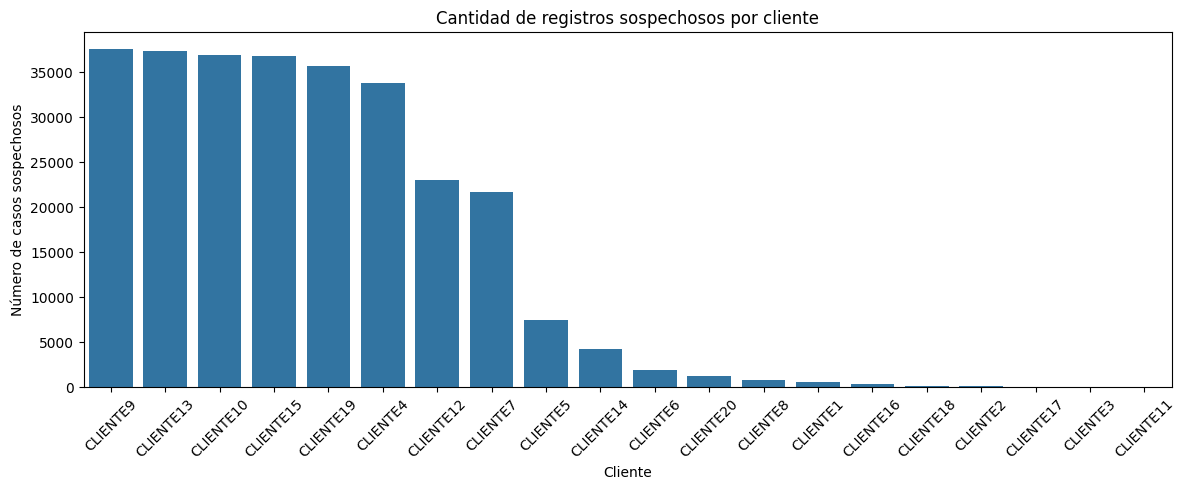

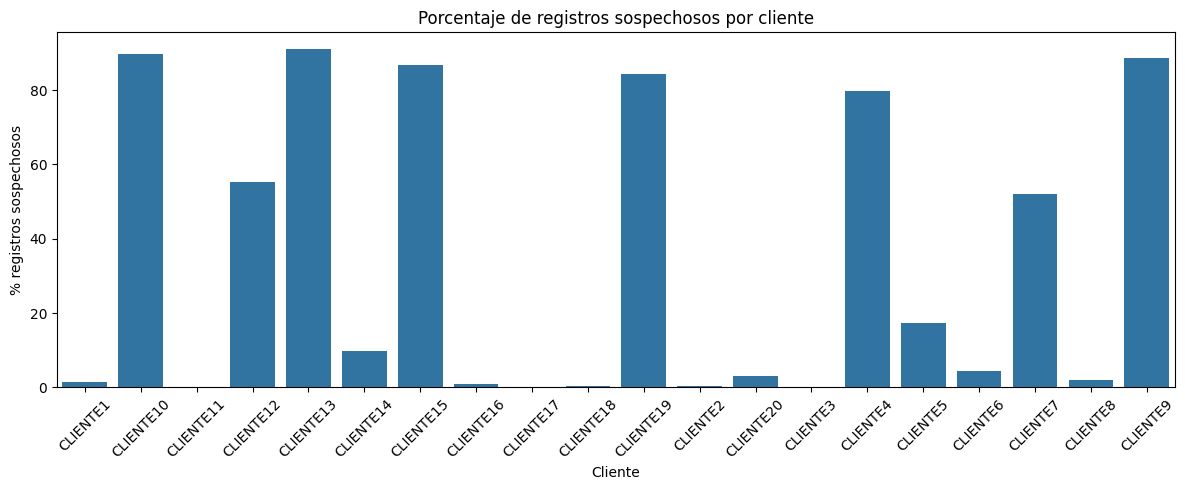

✅ Archivo guardado como 'datos_guardian_fraudes_con_sospechosos.csv'


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


archivo = "Datos.xlsx"  #
xls = pd.ExcelFile(archivo)


def procesar_cliente_con_indices(nombre_hoja, df):
    df.columns = df.columns.str.strip().str.lower()
    df.rename(columns={
        'fecha': 'fecha',
        'presion': 'presion',
        'temperatura': 'temperatura',
        'volumen': 'volumen'
    }, inplace=True)

    df['fecha'] = pd.to_datetime(df['fecha'], errors='coerce')
    df = df.drop_duplicates()
    df = df.dropna(subset=['presion', 'temperatura', 'volumen'])

    df['temperatura_k'] = df['temperatura'] + 273.15
    Z = 0.9
    df['indice_pvt_ideal'] = (df['presion'] * df['volumen']) / df['temperatura_k']
    df['indice_pvt_real'] = (df['presion'] * df['volumen']) / (Z * df['temperatura_k'])
    df['indice_vt'] = df['volumen'] / df['temperatura_k']
    df['indice_pv'] = df['presion'] / df['volumen']
    df['cliente'] = nombre_hoja

    return df[['fecha', 'presion', 'temperatura', 'temperatura_k', 'volumen',
               'indice_pvt_ideal', 'indice_pvt_real', 'indice_vt', 'indice_pv', 'cliente']]

#
df_completo = pd.DataFrame()
for hoja in xls.sheet_names:
    df_hoja = xls.parse(hoja)
    df_procesado = procesar_cliente_con_indices(hoja, df_hoja)
    df_completo = pd.concat([df_completo, df_procesado], ignore_index=True)

#
df_completo['sospechoso'] = (
    (df_completo['volumen'] <= 0.01) |
    (df_completo['indice_pv'].replace([np.inf, -np.inf], np.nan).isnull())
).astype(int)

df_completo.replace([np.inf, -np.inf], np.nan, inplace=True)

#Gráfica 1:
sospechosos_por_cliente = df_completo.groupby('cliente')['sospechoso'].sum().sort_values(ascending=False)
plt.figure(figsize=(12, 5))
sns.barplot(x=sospechosos_por_cliente.index, y=sospechosos_por_cliente.values)
plt.title("Cantidad de registros sospechosos por cliente")
plt.ylabel("Número de casos sospechosos")
plt.xlabel("Cliente")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#Gráfica 2
porcentaje_sospechosos = (sospechosos_por_cliente / df_completo['cliente'].value_counts()) * 100
plt.figure(figsize=(12, 5))
sns.barplot(x=porcentaje_sospechosos.index, y=porcentaje_sospechosos.values)
plt.title("Porcentaje de registros sospechosos por cliente")
plt.ylabel("% registros sospechosos")
plt.xlabel("Cliente")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Guardar el dataset procesado
df_completo.to_csv("datos_guardian_fraudes_con_sospechosos.csv", index=False)
print("Archivo guardado como 'datos_guardian_fraudes_con_sospechosos.csv'")


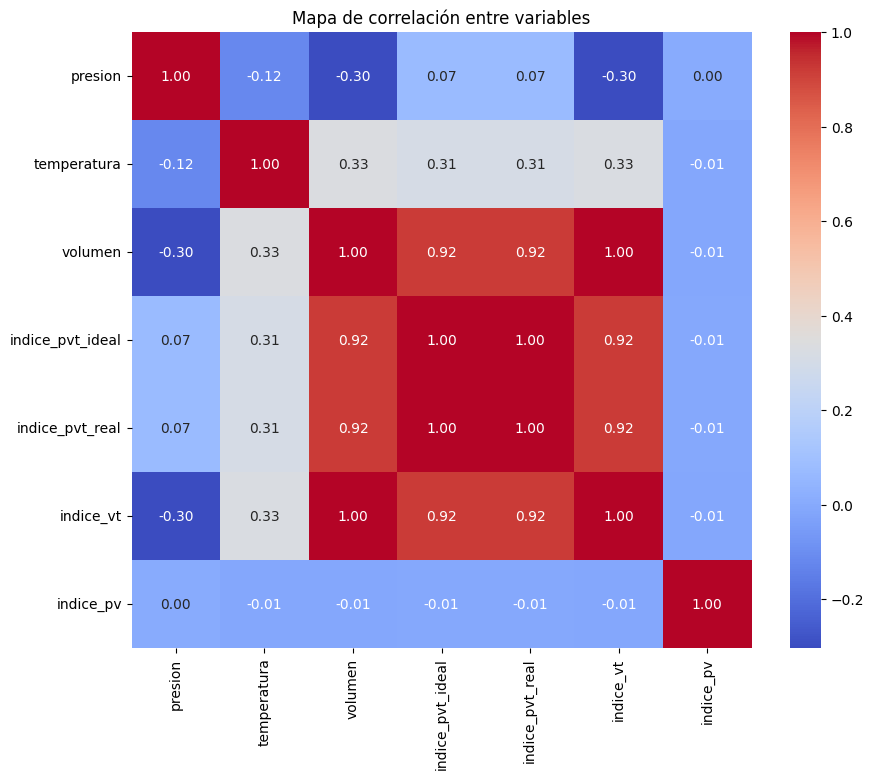

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(df_completo[['presion', 'temperatura', 'volumen',
                         'indice_pvt_ideal', 'indice_pvt_real',
                         'indice_vt', 'indice_pv']].corr(),
            annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Mapa de correlación entre variables")
plt.show()


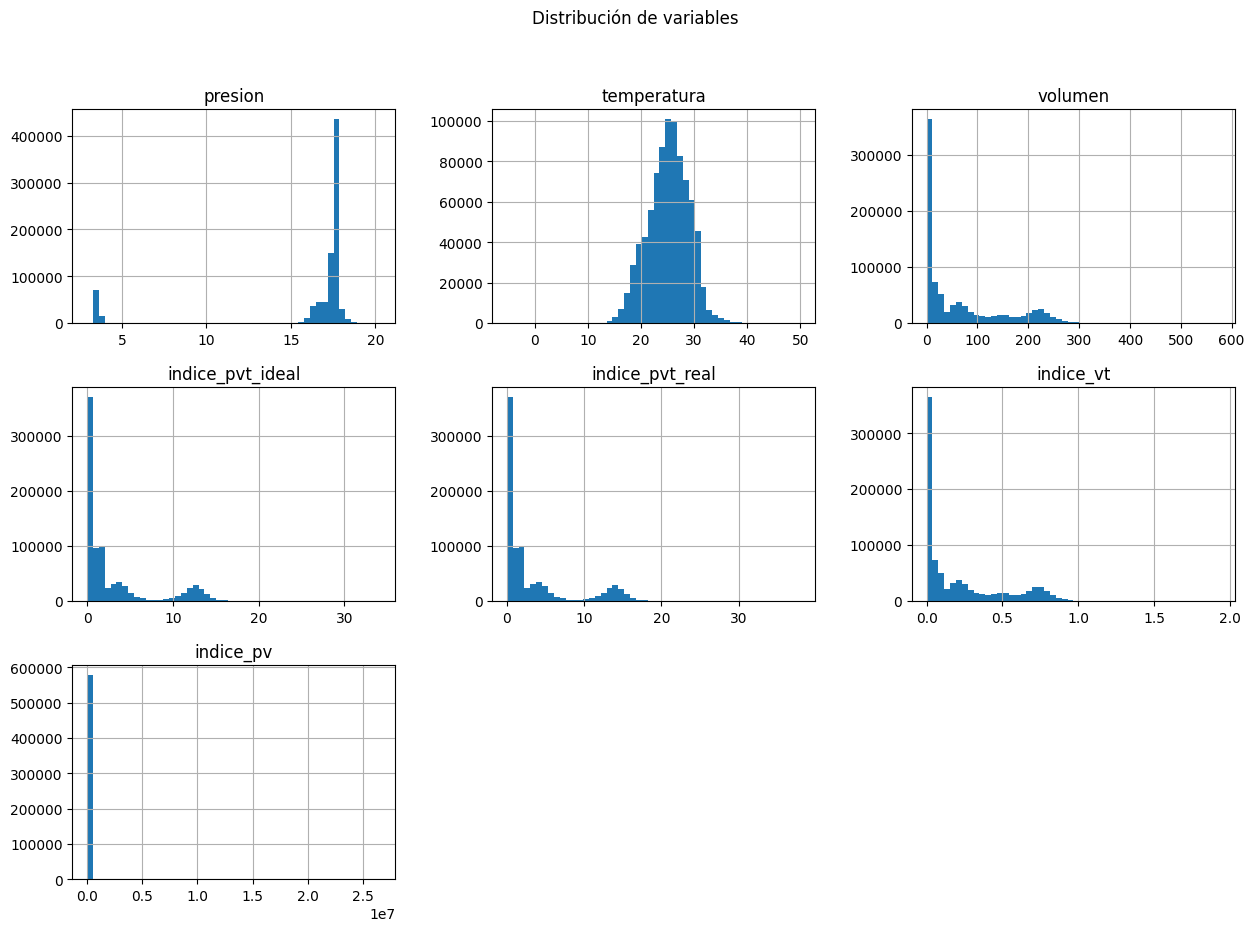

In [6]:
df_completo[['presion', 'temperatura', 'volumen',
             'indice_pvt_ideal', 'indice_pvt_real',
             'indice_vt', 'indice_pv']].hist(bins=50, figsize=(15, 10))
plt.suptitle("Distribución de variables")
plt.show()


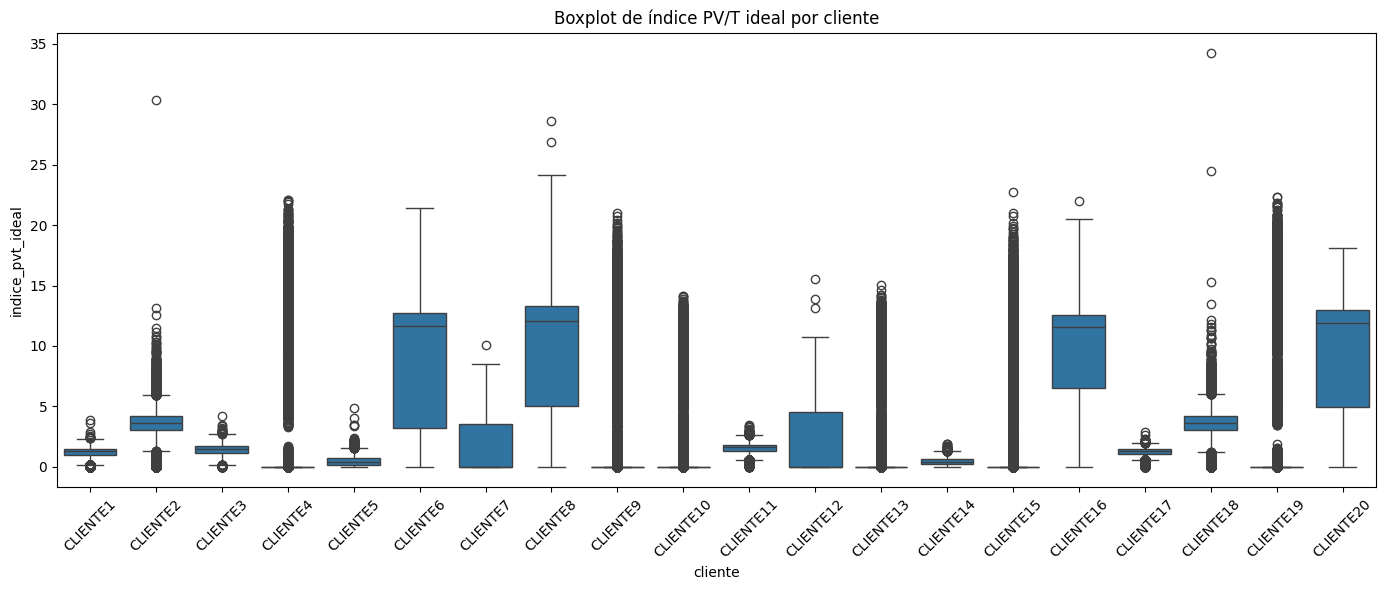

In [7]:
plt.figure(figsize=(14, 6))
sns.boxplot(data=df_completo, x='cliente', y='indice_pvt_ideal')
plt.xticks(rotation=45)
plt.title("Boxplot de índice PV/T ideal por cliente")
plt.tight_layout()
plt.show()


In [8]:

df_modelo = df_completo.copy()

# Variables seleccionadas:
# - presión
# - temperatura
# - volumen
# - índice físico real (PV / ZT)
# - índice P/V
# + fecha, cliente, y la bandera de sospechoso para trazabilidad y análisis futuro

variables_utiles = ['fecha', 'cliente', 'presion', 'temperatura', 'volumen',
                    'indice_pvt_real', 'indice_pv', 'sospechoso']

df_modelo = df_modelo[variables_utiles]

# Guardar dataset limpio y preparado para modelado
df_modelo.to_csv("datos_guardian_fraudes_modelo_v1.csv", index=False)
print("Archivo exportado: datos_guardian_fraudes_modelo_v1.csv")

✅ Archivo exportado: datos_guardian_fraudes_modelo_v1.csv


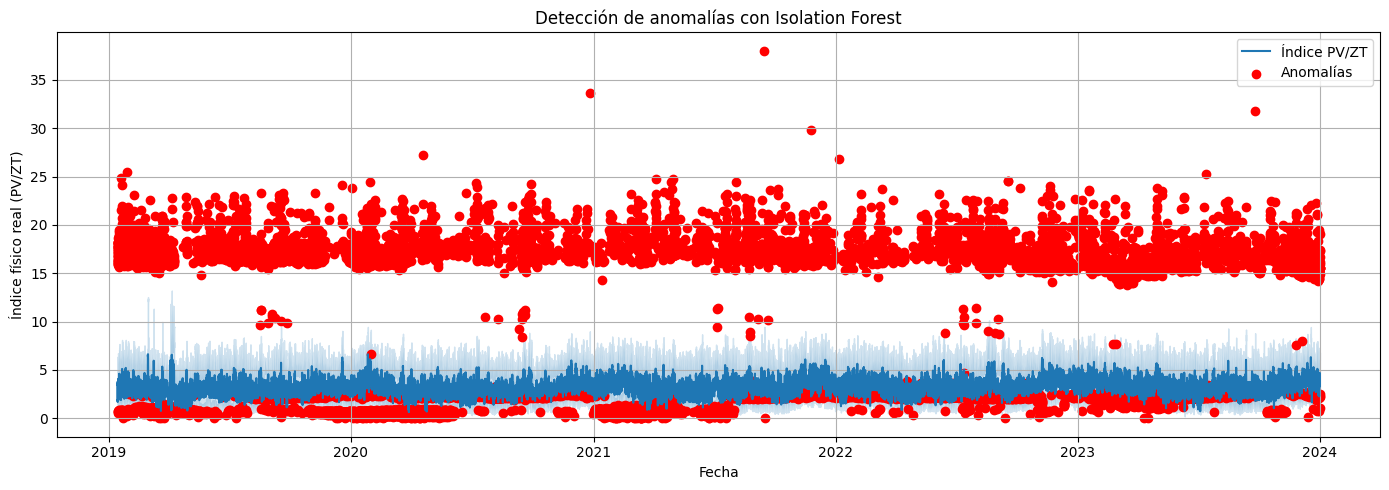

anomalía
Normal     822521
Anómalo     25439
Name: count, dtype: int64
✅ Resultados guardados en: resultados_isolation_forest.csv


In [9]:
#Entrenar Isolation Forest
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest


df = df_modelo

variables = ['presion', 'temperatura', 'volumen', 'indice_pvt_real', 'indice_pv']
X = df[variables]


modelo_iforest = IsolationForest(n_estimators=100, contamination=0.03, random_state=42)
modelo_iforest.fit(X)

df['anomaly_score'] = modelo_iforest.decision_function(X)
df['anomalía'] = modelo_iforest.predict(X)  # -1 = anómalo, 1 = normal
df['anomalía'] = df['anomalía'].map({1: 'Normal', -1: 'Anómalo'})

plt.figure(figsize=(14, 5))
sns.lineplot(x=pd.to_datetime(df['fecha']), y=df['indice_pvt_real'], label='Índice PV/ZT')
anomalías = df[df['anomalía'] == 'Anómalo']
plt.scatter(pd.to_datetime(anomalías['fecha']), anomalías['indice_pvt_real'], color='red', label='Anomalías')
plt.title('Detección de anomalías con Isolation Forest')
plt.xlabel('Fecha')
plt.ylabel('Índice físico real (PV/ZT)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
print(df['anomalía'].value_counts())
df.to_csv("resultados_isolation_forest.csv", index=False)
print(" Resultados guardados en: resultados_isolation_forest.csv")


🔝 Top 10 tasas de anomalías más altas (cliente - año):
cliente    año 
CLIENTE3   2020    36.94
           2021    35.20
CLIENTE11  2021    34.18
           2023    22.78
           2019    19.98
CLIENTE8   2019    19.01
CLIENTE3   2023    17.81
CLIENTE11  2022    15.50
           2020    12.01
CLIENTE3   2022    10.65
dtype: float64


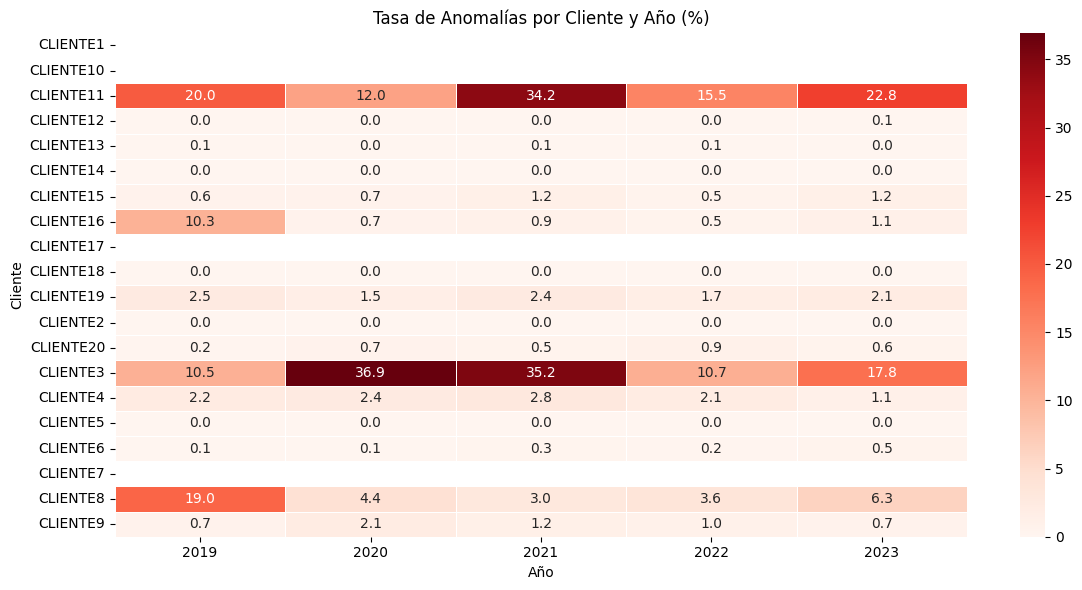

In [10]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv("resultados_isolation_forest.csv")
df['fecha'] = pd.to_datetime(df['fecha'])
df['año'] = df['fecha'].dt.year


df = df[df['anomalía'].isin(['Normal', 'Anómalo'])]


anomalías_por_cliente_año = df[df['anomalía'] == 'Anómalo'] \
    .groupby(['cliente', 'año'])['anomalía'].count().unstack(fill_value=0)

total_por_cliente_año = df.groupby(['cliente', 'año'])['anomalía'].count().unstack(fill_value=0)

tasa_anomalia = (anomalías_por_cliente_año / total_por_cliente_año * 100).round(2)

top_tasas = tasa_anomalia.stack().sort_values(ascending=False).head(10)
print("🔝 Top 10 tasas de anomalías más altas (cliente - año):")
print(top_tasas)

plt.figure(figsize=(12, 6))
sns.heatmap(tasa_anomalia, annot=True, cmap="Reds", fmt=".1f", linewidths=.5)
plt.title("Tasa de Anomalías por Cliente y Año (%)")
plt.xlabel("Año")
plt.ylabel("Cliente")
plt.tight_layout()
plt.show()


sospechoso_binario    No sospechoso  Sospechoso     All
anomalía_mahalanobis                                   
Anómalo                       20746         135   20881
Normal                       546909        9510  556419
All                          567655        9645  577300


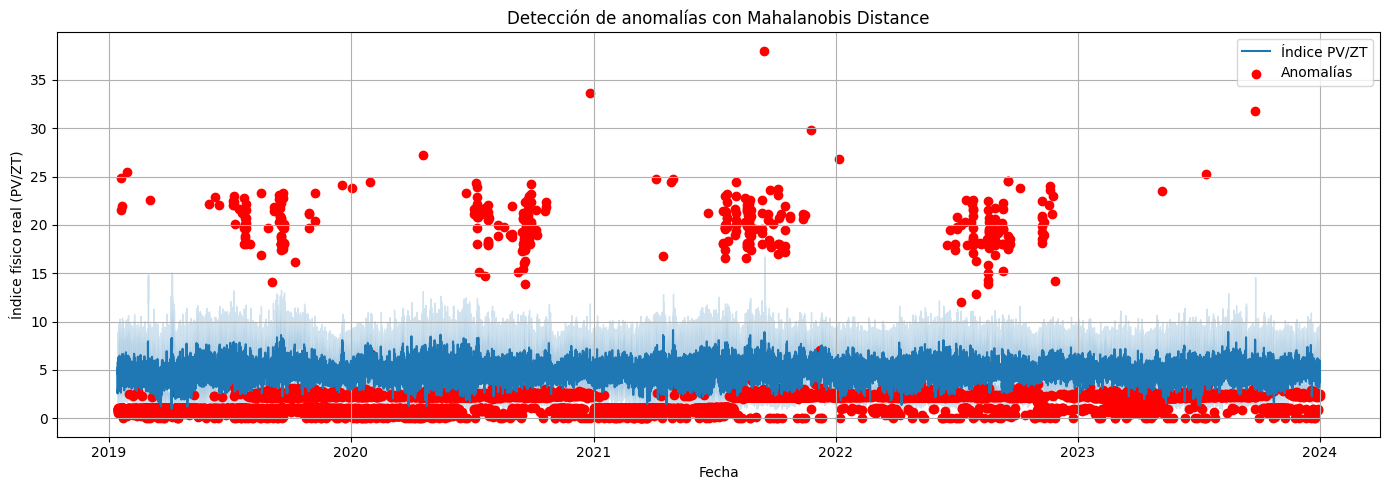

✅ Resultados guardados en: resultados_mahalanobis.csv


In [11]:
# 🧠distancia de Mahalanobis
import pandas as pd
import numpy as np
from scipy.spatial.distance import mahalanobis
from scipy.stats import chi2
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv("datos_guardian_fraudes_modelo_v1.csv")


variables = ['presion', 'temperatura', 'volumen', 'indice_pvt_real', 'indice_pv']
df = df.dropna(subset=variables).copy()


X = df[variables]
mu = X.mean().values
cov = np.cov(X.values.T)
inv_cov = np.linalg.inv(cov)


df['mahalanobis_dist'] = X.apply(lambda row: mahalanobis(row, mu, inv_cov), axis=1)


umbral = chi2.ppf(0.99, df=X.shape[1])
df['anomalía_mahalanobis'] = (df['mahalanobis_dist'] ** 2 > umbral).map({True: 'Anómalo', False: 'Normal'})

df['sospechoso_binario'] = df['sospechoso'].map({1: 'Sospechoso', 0: 'No sospechoso'})
print(pd.crosstab(df['anomalía_mahalanobis'], df['sospechoso_binario'], margins=True))

df['fecha'] = pd.to_datetime(df['fecha'])
plt.figure(figsize=(14, 5))
sns.lineplot(data=df, x='fecha', y='indice_pvt_real', label='Índice PV/ZT')
anomalías = df[df['anomalía_mahalanobis'] == 'Anómalo']
plt.scatter(anomalías['fecha'], anomalías['indice_pvt_real'], color='red', label='Anomalías')
plt.title('Detección de anomalías con Mahalanobis Distance')
plt.xlabel('Fecha')
plt.ylabel('Índice físico real (PV/ZT)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

df.to_csv("resultados_mahalanobis.csv", index=False)
print("Resultados guardados en: resultados_mahalanobis.csv")


sospechoso_binario  No sospechoso  Sospechoso     All
anomalía_svm                                         
Anómalo                     16163        1155   17318
Normal                     551492        8490  559982
All                        567655        9645  577300


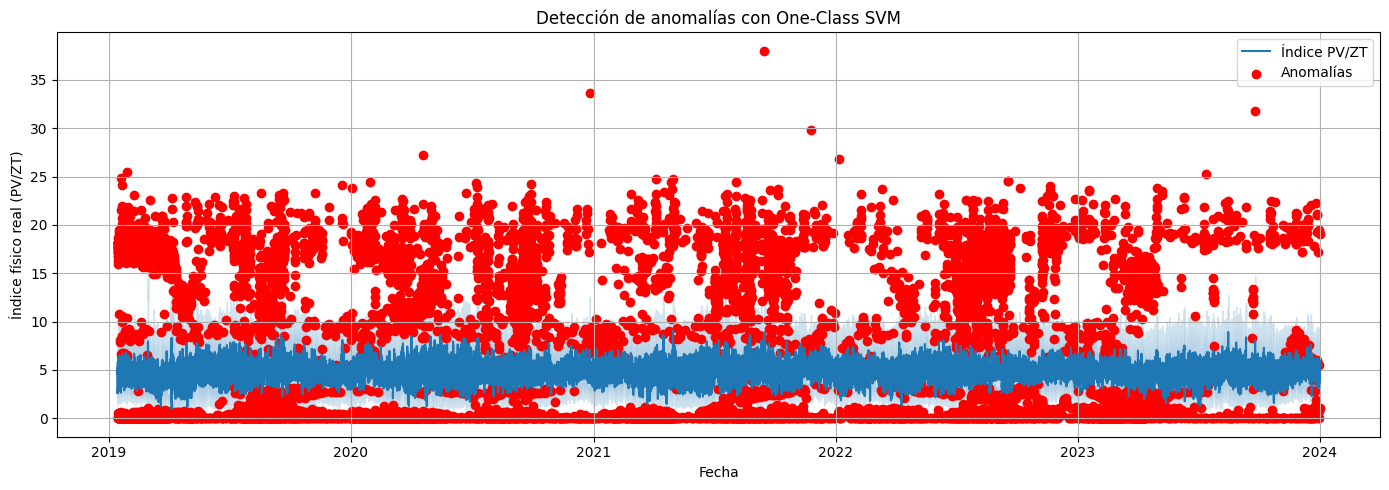

✅ Resultados guardados en: resultados_oneclass_svm.csv


In [12]:
#Entrenar One-Class SVM
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix


df = pd.read_csv("datos_guardian_fraudes_modelo_v1.csv")

variables = ['presion', 'temperatura', 'volumen', 'indice_pvt_real', 'indice_pv']
df = df.dropna(subset=variables).copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[variables])

modelo_svm = OneClassSVM(kernel='rbf', nu=0.03, gamma='scale')  # gamma puede ajustarse
modelo_svm.fit(X_scaled)
df['anomalía_svm'] = modelo_svm.predict(X_scaled)  # -1 anómalo, 1 normal
df['anomalía_svm'] = df['anomalía_svm'].map({1: 'Normal', -1: 'Anómalo'})
df['sospechoso_binario'] = df['sospechoso'].map({1: 'Sospechoso', 0: 'No sospechoso'})
print(pd.crosstab(df['anomalía_svm'], df['sospechoso_binario'], margins=True))

df['fecha'] = pd.to_datetime(df['fecha'])
plt.figure(figsize=(14, 5))
sns.lineplot(data=df, x='fecha', y='indice_pvt_real', label='Índice PV/ZT')
plt.scatter(df[df['anomalía_svm'] == 'Anómalo']['fecha'],
            df[df['anomalía_svm'] == 'Anómalo']['indice_pvt_real'],
            color='red', label='Anomalías')
plt.title('Detección de anomalías con One-Class SVM')
plt.xlabel('Fecha')
plt.ylabel('Índice físico real (PV/ZT)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

df.to_csv("resultados_oneclass_svm.csv", index=False)
print("Resultados guardados en: resultados_oneclass_svm.csv")



📊 Comparación por percentiles:
sospechoso_binario  No sospechoso  Sospechoso     All
anomalía_percentil                                   
Anómalo                     42398           0   42398
Normal                     525257      280305  805562
All                        567655      280305  847960

📊 Comparación por derivada Z-score:
sospechoso_binario  No sospechoso  Sospechoso     All
anomalía_derivada                                    
Anómalo                     22128         321   22449
Normal                     545527      279984  825511
All                        567655      280305  847960

📊 Comparación por Z físico por cliente:
sospechoso_binario  No sospechoso  Sospechoso     All
anomalía_z_cliente                                   
Anómalo                     13594         440   14034
Normal                     554061      279865  833926
All                        567655      280305  847960


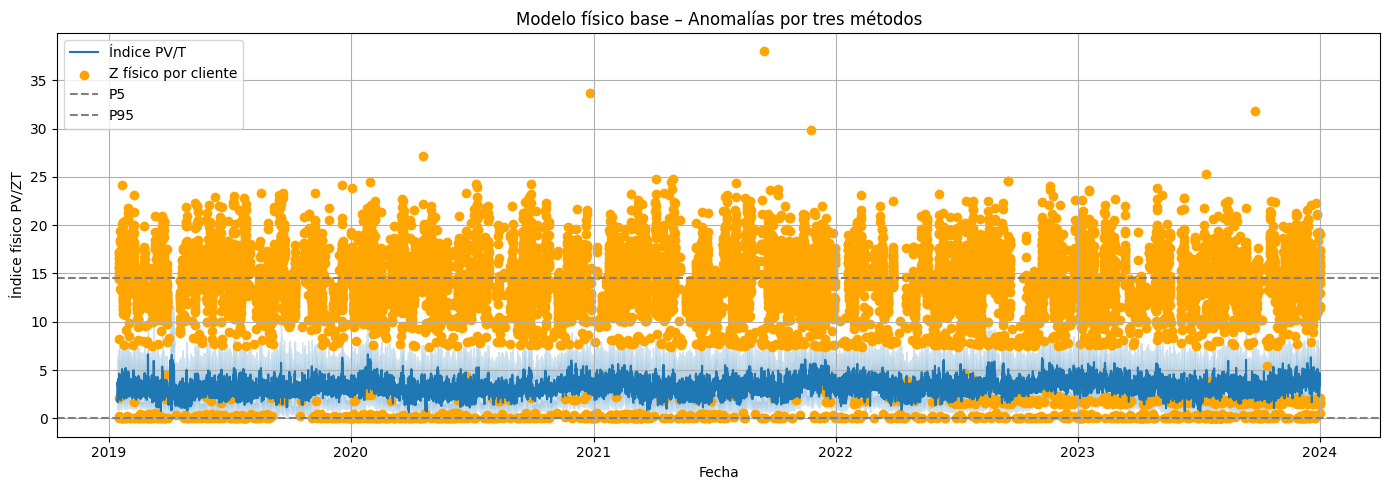

✅ Resultados guardados como: resultados_modelo_fisico_base.csv


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv("datos_guardian_fraudes_modelo_v1.csv")
df['fecha'] = pd.to_datetime(df['fecha'])


# Anomalías por percentiles globales

p5 = df['indice_pvt_real'].quantile(0.05)
p95 = df['indice_pvt_real'].quantile(0.95)

df['anomalía_percentil'] = df['indice_pvt_real'].apply(
    lambda x: 'Anómalo' if (x < p5 or x > p95) else 'Normal'
)


# Anomalías por derivada y Z-score

df['derivada_pvt'] = df['indice_pvt_real'].diff()
mu_der = df['derivada_pvt'].mean()
std_der = df['derivada_pvt'].std()
df['zscore_derivada'] = (df['derivada_pvt'] - mu_der) / std_der

# Umbral ±3σ para derivadas
df['anomalía_derivada'] = df['zscore_derivada'].apply(
    lambda z: 'Anómalo' if abs(z) > 3 else 'Normal'
)


# Anomalías por Z físico por cliente (normalización intra-cliente)

df['zscore_pvt_cliente'] = df.groupby('cliente')['indice_pvt_real'].transform(
    lambda x: (x - x.mean()) / x.std()
)

df['anomalía_z_cliente'] = df['zscore_pvt_cliente'].apply(
    lambda z: 'Anómalo' if abs(z) > 3 else 'Normal'
)

# Comparación general
df['sospechoso_binario'] = df['sospechoso'].map({1: 'Sospechoso', 0: 'No sospechoso'})

print("📊 Comparación por percentiles:")
print(pd.crosstab(df['anomalía_percentil'], df['sospechoso_binario'], margins=True))

print("\n📊 Comparación por derivada Z-score:")
print(pd.crosstab(df['anomalía_derivada'], df['sospechoso_binario'], margins=True))

print("\n📊 Comparación por Z físico por cliente:")
print(pd.crosstab(df['anomalía_z_cliente'], df['sospechoso_binario'], margins=True))


plt.figure(figsize=(14, 5))
sns.lineplot(data=df, x='fecha', y='indice_pvt_real', label='Índice PV/T')

# Superponer anomalías
plt.scatter(df[df['anomalía_z_cliente'] == 'Anómalo']['fecha'],
            df[df['anomalía_z_cliente'] == 'Anómalo']['indice_pvt_real'],
            color='orange', label='Z físico por cliente')


plt.axhline(p5, color='gray', linestyle='--', label='P5')
plt.axhline(p95, color='gray', linestyle='--', label='P95')

plt.title("Modelo físico base – Anomalías por tres métodos")
plt.xlabel("Fecha")
plt.ylabel("Índice físico PV/ZT")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
df.to_csv("resultados_modelo_fisico_base.csv", index=False)
print("Resultados guardados como: resultados_modelo_fisico_base.csv")


sospechoso_binario  No sospechoso  Sospechoso     All
anomalía_zscore                                      
Anómalo                      1990           0    1990
Normal                     565665      280305  845970
All                        567655      280305  847960


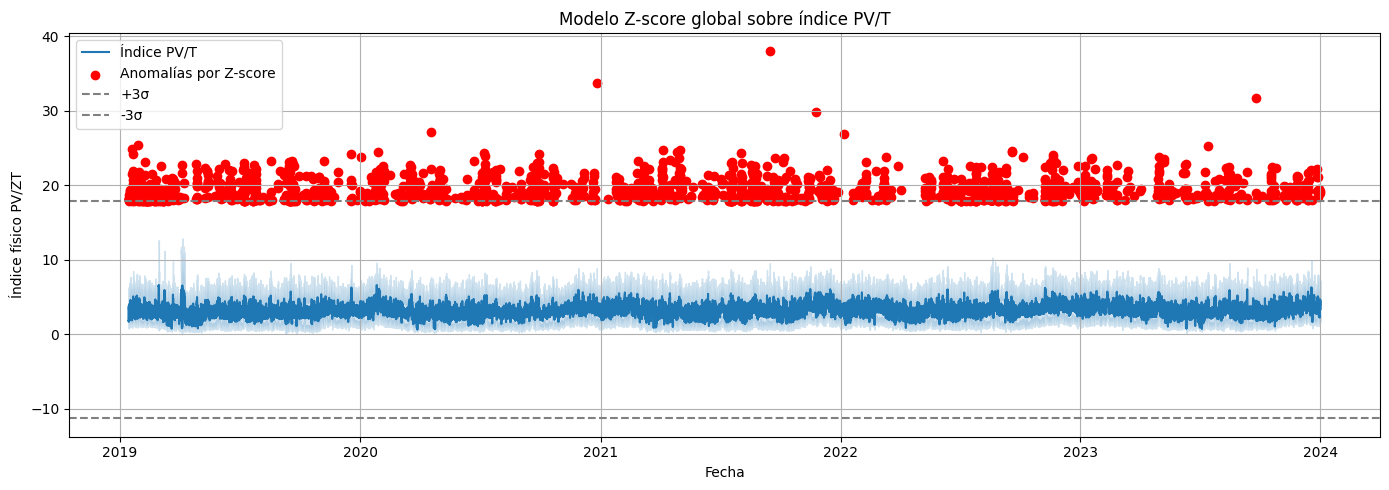

✅ Resultados guardados como: resultados_zscore_global.csv


In [14]:

df = pd.read_csv("datos_guardian_fraudes_modelo_v1.csv")
df['fecha'] = pd.to_datetime(df['fecha'])

# Calcular Z-score del índice físico
mu = df['indice_pvt_real'].mean()
std = df['indice_pvt_real'].std()
df['zscore_pvt'] = (df['indice_pvt_real'] - mu) / std


df['anomalía_zscore'] = df['zscore_pvt'].apply(
    lambda z: 'Anómalo' if abs(z) > 3 else 'Normal'
)


df['sospechoso_binario'] = df['sospechoso'].map({1: 'Sospechoso', 0: 'No sospechoso'})
print(pd.crosstab(df['anomalía_zscore'], df['sospechoso_binario'], margins=True))


plt.figure(figsize=(14, 5))
sns.lineplot(data=df, x='fecha', y='indice_pvt_real', label='Índice PV/T')
plt.scatter(df[df['anomalía_zscore'] == 'Anómalo']['fecha'],
            df[df['anomalía_zscore'] == 'Anómalo']['indice_pvt_real'],
            color='red', label='Anomalías por Z-score')
plt.axhline(mu + 3*std, linestyle='--', color='gray', label='+3σ')
plt.axhline(mu - 3*std, linestyle='--', color='gray', label='-3σ')
plt.title("Modelo Z-score global sobre índice PV/T")
plt.xlabel("Fecha")
plt.ylabel("Índice físico PV/ZT")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


df.to_csv("resultados_zscore_global.csv", index=False)
print("Resultados guardados como: resultados_zscore_global.csv")


  0%|          | 0/20 [00:00<?, ?it/s]DEBUG:cmdstanpy:input tempfile: /tmp/tmpf2zhwdum/66zz1h8b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpf2zhwdum/8hp2lqnt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29680', 'data', 'file=/tmp/tmpf2zhwdum/66zz1h8b.json', 'init=/tmp/tmpf2zhwdum/8hp2lqnt.json', 'output', 'file=/tmp/tmpf2zhwdum/prophet_modelif2v8xo_/prophet_model-20250511152650.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:26:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:27:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
  5%|▌         | 1/20 [01:11<22:45, 71.88s/it]DEBUG:cmdstanpy:input tempfile: /tmp/tmpf2zhwdum/0psg__8n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpf2zhwdum/vrc1hmc5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmds

Archivos generados:
- resultados_prophet_general.csv
- anomalías_por_cliente_año.csv


<ipython-input-15-ccabdb7f2102>:75: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-15-ccabdb7f2102>:76: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.savefig("heatmap_anomalías_prophet.png", dpi=300)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


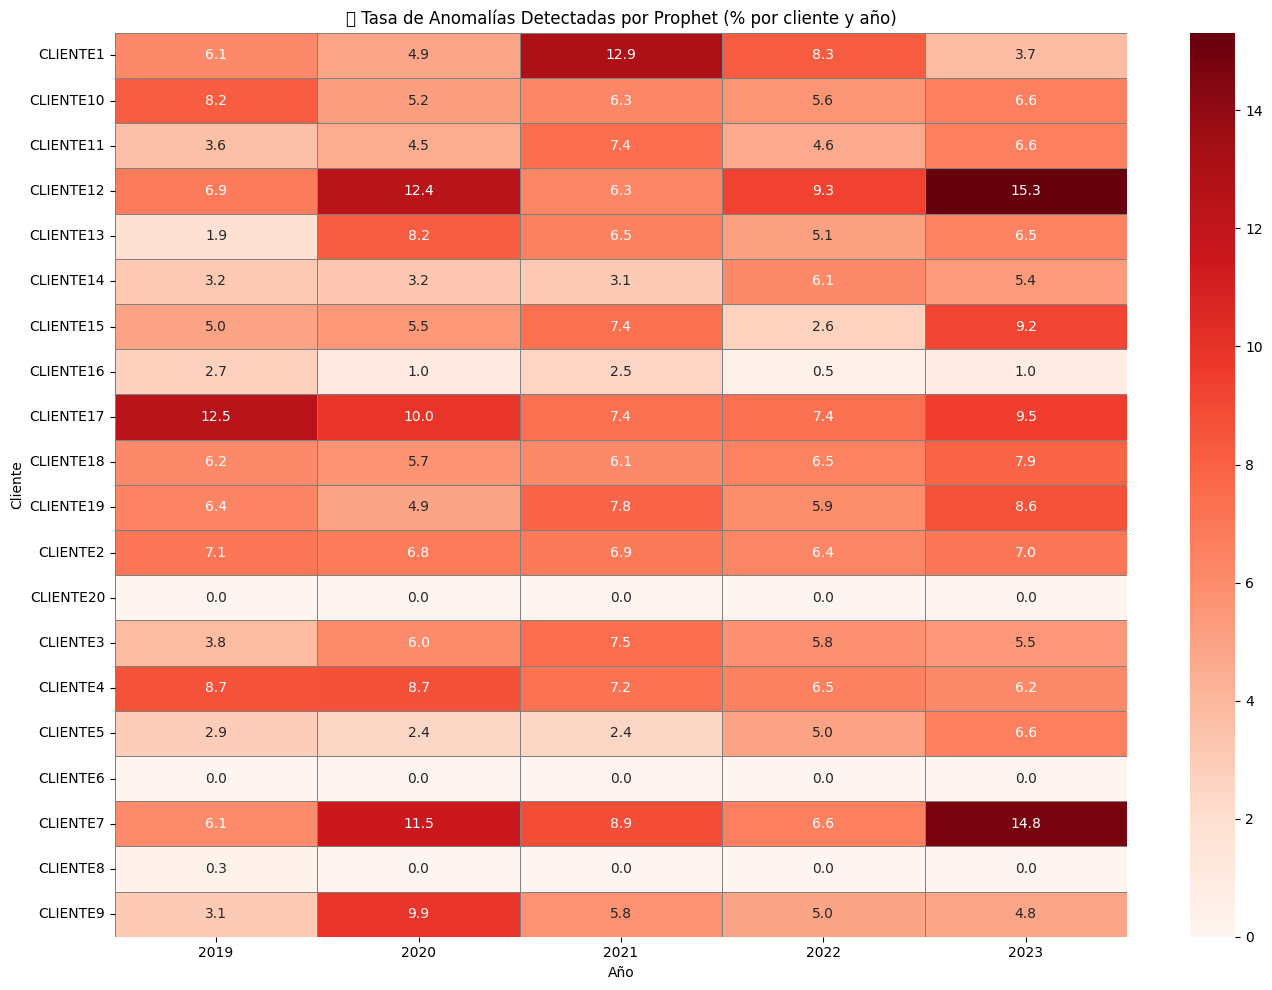

Heatmap guardado como 'heatmap_anomalías_prophet.png'


In [15]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm

df = pd.read_csv("datos_guardian_fraudes_modelo_v1.csv")
df['fecha'] = pd.to_datetime(df['fecha'])
campo_modelar = 'indice_pvt_real'


df_general_resultados = []


tabla_anual = []

# Recorrer clientes
for cliente in tqdm(df['cliente'].unique()):

    df_cliente = df[df['cliente'] == cliente].copy()
    df_cliente = df_cliente[['fecha', campo_modelar]].rename(columns={'fecha': 'ds', campo_modelar: 'y'}).dropna()

    if len(df_cliente) < 60:
        continue

    #Entrenar Prophet
    modelo = Prophet(daily_seasonality=False, yearly_seasonality=True)
    modelo.fit(df_cliente)

    #Predicción
    futuro = modelo.make_future_dataframe(periods=0)
    forecast = modelo.predict(futuro)

    df_pred = df_cliente.merge(forecast[['ds', 'yhat']], on='ds')
    df_pred['error'] = df_pred['y'] - df_pred['yhat']
    df_pred['error_abs'] = abs(df_pred['error'])

    umbral = df_pred['error_abs'].mean() * 2.5
    df_pred['anomalía_prophet'] = df_pred['error_abs'].apply(lambda x: 'Anómalo' if x > umbral else 'Normal')
    df_pred['cliente'] = cliente
    df_pred['año'] = df_pred['ds'].dt.year

    # Guardar al consolidado general
    df_general_resultados.append(df_pred)

    # Calcular anomalías por año
    resumen = df_pred.groupby('año')['anomalía_prophet'].value_counts().unstack().fillna(0)
    resumen['cliente'] = cliente
    resumen_numeric = resumen.select_dtypes(include='number')
    resumen['total'] = resumen_numeric.sum(axis=1)
    resumen['tasa_anomalías_%'] = (resumen.get('Anómalo', 0) / resumen['total']) * 100
    tabla_anual.append(resumen.reset_index())


df_resultado_general = pd.concat(df_general_resultados, ignore_index=True)
df_tabla_anual = pd.concat(tabla_anual, ignore_index=True)


df_resultado_general.to_csv("resultados_prophet_general.csv", index=False)
df_tabla_anual.to_csv("anomalías_por_cliente_año.csv", index=False)

print("Archivos generados:")
print("- resultados_prophet_general.csv")
print("- anomalías_por_cliente_año.csv")


df_heatmap = df_tabla_anual.pivot(index='cliente', columns='año', values='tasa_anomalías_%').fillna(0)

plt.figure(figsize=(14, max(6, int(len(df_heatmap)/2))))
sns.heatmap(df_heatmap, annot=True, fmt=".1f", cmap="Reds", linewidths=.5, linecolor='gray')
plt.title("Tasa de Anomalías Detectadas por Prophet (% por cliente y año)")
plt.xlabel("Año")
plt.ylabel("Cliente")
plt.tight_layout()
plt.savefig("heatmap_anomalías_prophet.png", dpi=300)
plt.show()

print("Heatmap guardado como 'heatmap_anomalías_prophet.png'")


Epoch 1/50
7217/7217 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - loss: 0.2893 - val_loss: 0.1815
Epoch 2/50
7217/7217 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - loss: 0.2362 - val_loss: 0.0024
Epoch 3/50
7217/7217 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - loss: 0.0024 - val_loss: 0.0793
Epoch 4/50
7217/7217 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 0.0035 - val_loss: 0.0286
Epoch 5/50
7217/7217 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 0.0113 - val_loss: 0.0066
Epoch 6/50
7217/7217 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - loss: 0.0042 - val_loss: 0.0133
Epoch 7/50
7217/7217 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - loss: 0.0075 - val_loss: 8.7608e-04
Epoch 8/50
7217/7217 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - loss: 0.0213 - val_loss: 9.4982e-04
Epoch 9/50
7217/7217 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - loss: 0.0011 - val_loss: 2.0153e-04
Epoch 10/50
7217/7217 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - loss: 0.0110 - val_loss: 0.0014
Epoch 11/50
7217/7217 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - loss: 0.0013 - val_loss: 0.0401
Epoch 1

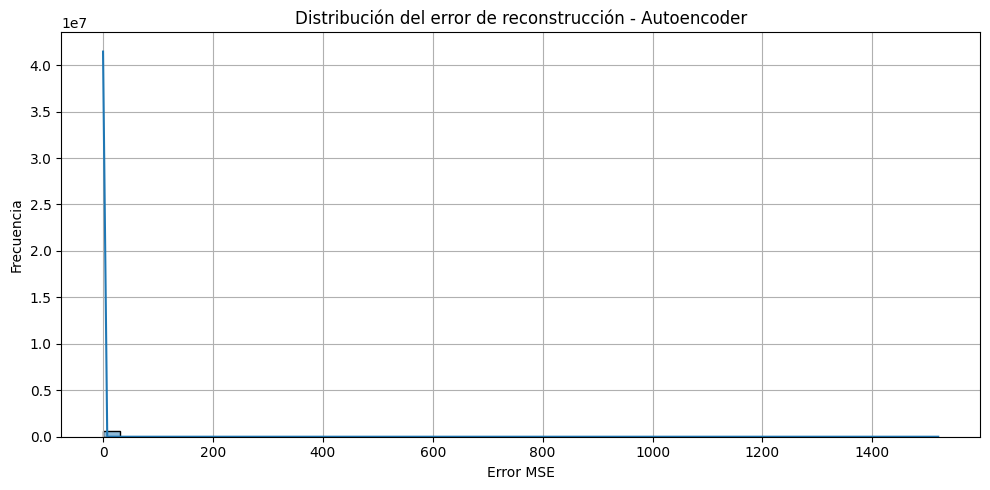

sospechoso_binario    No sospechoso  Sospechoso     All
anomalía_autoencoder                                   
Anómalo                       25865        3000   28865
Normal                       541790        6645  548435
All                          567655        9645  577300
Resultados guardados como: resultados_autoencoder_general.csv


In [20]:
#Definir Autoencoder
df = pd.read_csv("datos_guardian_fraudes_modelo_v1.csv")


features = ['presion', 'temperatura', 'volumen', 'indice_pvt_real', 'indice_pv']
df = df.dropna(subset=features).copy()
X = df[features]


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


X_train, X_test = train_test_split(X_scaled, test_size=0.2, random_state=42)


input_dim = X_train.shape[1]
input_layer = Input(shape=(input_dim,))
encoded = Dense(8, activation='relu')(input_layer)
encoded = Dense(4, activation='relu')(encoded)
decoded = Dense(8, activation='relu')(encoded)
output_layer = Dense(input_dim, activation='linear')(decoded)

autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')


history = autoencoder.fit(X_train, X_train,
                          epochs=50,
                          batch_size=64,
                          validation_data=(X_test, X_test),
                          verbose=1)

X_pred = autoencoder.predict(X_scaled)
mse = np.mean(np.power(X_scaled - X_pred, 2), axis=1)
df['reconstruction_error'] = mse


plt.figure(figsize=(10, 5))
sns.histplot(df['reconstruction_error'], bins=50, kde=True)
plt.title("Distribución del error de reconstrucción - Autoencoder")
plt.xlabel("Error MSE")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.tight_layout()
plt.show()


umbral = np.percentile(df['reconstruction_error'], 95)
df['anomalía_autoencoder'] = df['reconstruction_error'].apply(lambda x: 'Anómalo' if x > umbral else 'Normal')

df['sospechoso_binario'] = df['sospechoso'].map({1: 'Sospechoso', 0: 'No sospechoso'})
print(pd.crosstab(df['anomalía_autoencoder'], df['sospechoso_binario'], margins=True))


df.to_csv("resultados_autoencoder_general.csv", index=False)
print("Resultados guardados como: resultados_autoencoder_general.csv")


In [21]:

df = pd.read_csv("datos_guardian_fraudes_modelo_v1.csv")

features = ['presion', 'temperatura', 'volumen', 'indice_pvt_real', 'indice_pv']

os.makedirs("resultados_autoencoder_por_cliente", exist_ok=True)

resultados_totales = []

for cliente in tqdm(df['cliente'].unique()):
    df_cliente = df[df['cliente'] == cliente].dropna(subset=features).copy()

    if len(df_cliente) < 200:  # puedes ajustar este mínimo
        continue

    # Escalar datos del cliente
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df_cliente[features])

    # Estructura del Autoencoder
    input_dim = X_scaled.shape[1]
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(8, activation='relu')(input_layer)
    encoded = Dense(4, activation='relu')(encoded)
    decoded = Dense(8, activation='relu')(encoded)
    output_layer = Dense(input_dim, activation='linear')(decoded)

    autoencoder = Model(inputs=input_layer, outputs=output_layer)
    autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')


    autoencoder.fit(X_scaled, X_scaled, epochs=40, batch_size=64, verbose=0)


    X_pred = autoencoder.predict(X_scaled)
    mse = np.mean(np.power(X_scaled - X_pred, 2), axis=1)
    df_cliente['reconstruction_error'] = mse


    umbral = np.percentile(mse, 95)
    df_cliente['anomalía_autoencoder_cliente'] = df_cliente['reconstruction_error'].apply(
        lambda x: 'Anómalo' if x > umbral else 'Normal'
    )


    df_cliente.to_csv(f"resultados_autoencoder_por_cliente/{cliente}_autoencoder.csv", index=False)
    resultados_totales.append(df_cliente)


df_total = pd.concat(resultados_totales, ignore_index=True)
df_total.to_csv("autoencoder_por_cliente_general.csv", index=False)

print("Modelos entrenados y resultados guardados en:")
print("- resultados_autoencoder_por_cliente/")
print("- autoencoder_por_cliente_general.csv")


  0%|          | 0/20 [00:00<?, ?it/s]

1338/1338 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


  5%|▌         | 1/20 [01:10<22:19, 70.50s/it]

1289/1289 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 10%|█         | 2/20 [02:11<19:29, 64.99s/it]

1319/1319 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 15%|█▌        | 3/20 [03:39<21:25, 75.61s/it]

386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 20%|██        | 4/20 [04:03<14:42, 55.18s/it]

1123/1123 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 25%|██▌       | 5/20 [05:05<14:22, 57.47s/it]

1279/1279 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


 30%|███       | 6/20 [06:08<13:54, 59.57s/it]

626/626 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 35%|███▌      | 7/20 [06:39<10:52, 50.19s/it]

1323/1323 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 40%|████      | 8/20 [07:45<11:00, 55.00s/it]

158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 45%|████▌     | 9/20 [07:57<07:37, 41.63s/it]

161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 50%|█████     | 10/20 [08:10<05:27, 32.70s/it]

1320/1320 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


 55%|█████▌    | 11/20 [09:12<06:15, 41.75s/it]

585/585 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 60%|██████    | 12/20 [09:42<05:05, 38.19s/it]

177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 65%|██████▌   | 13/20 [09:56<03:36, 30.88s/it]

1225/1225 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 70%|███████   | 14/20 [11:36<05:10, 51.81s/it]

175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 75%|███████▌  | 15/20 [11:50<03:21, 40.39s/it]

1337/1337 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 80%|████████  | 16/20 [12:53<03:09, 47.34s/it]

1355/1355 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 85%|████████▌ | 17/20 [13:58<02:37, 52.64s/it]

1288/1288 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 90%|█████████ | 18/20 [15:02<01:52, 56.00s/it]

287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 95%|█████████▌| 19/20 [15:19<00:44, 44.32s/it]

1299/1299 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


100%|██████████| 20/20 [16:24<00:00, 49.21s/it]


Modelos entrenados y resultados guardados en:
- resultados_autoencoder_por_cliente/
- autoencoder_por_cliente_general.csv


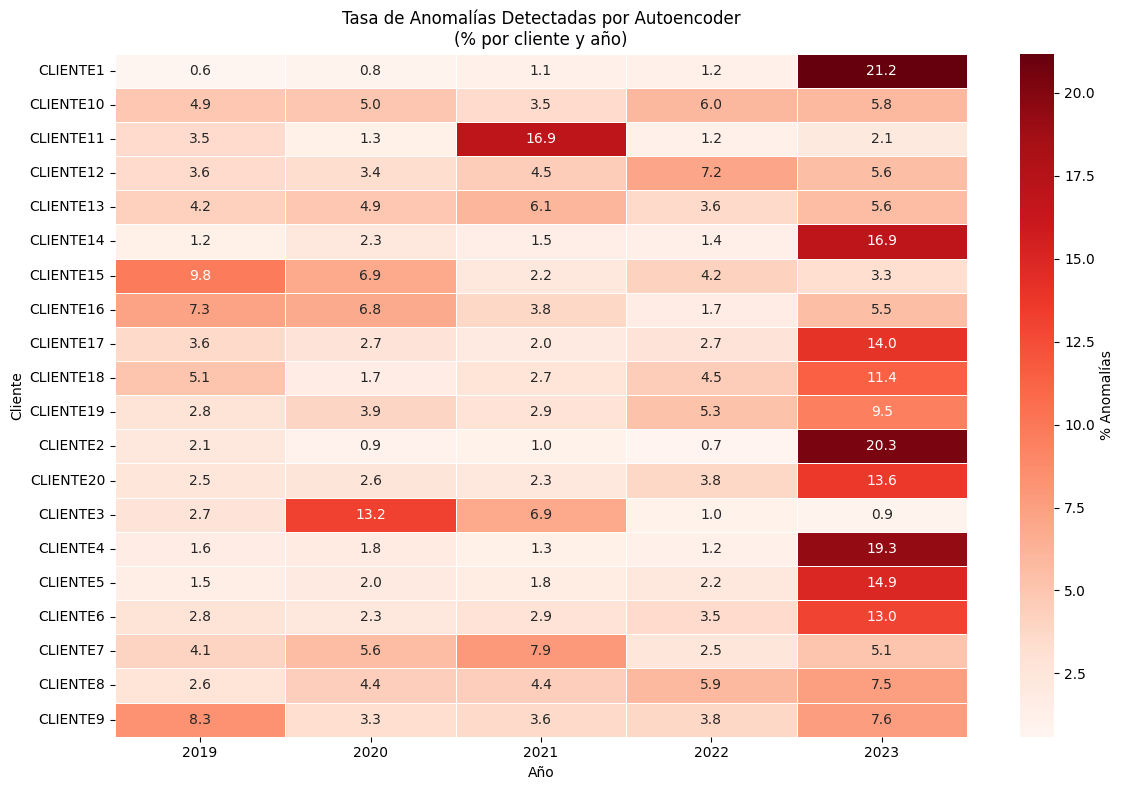

In [22]:
df = pd.read_csv("autoencoder_por_cliente_general.csv")

df['fecha'] = pd.to_datetime(df['fecha'])
df['año'] = df['fecha'].dt.year


tabla = df.groupby(['cliente', 'año'])['anomalía_autoencoder_cliente'].value_counts().unstack().fillna(0)


if 'Anómalo' not in tabla.columns:
    tabla['Anómalo'] = 0
if 'Normal' not in tabla.columns:
    tabla['Normal'] = 0


tabla['total'] = tabla['Anómalo'] + tabla['Normal']
tabla['tasa_anomalías_%'] = (tabla['Anómalo'] / tabla['total']) * 100


tabla_heatmap = tabla['tasa_anomalías_%'].unstack().fillna(0)


plt.figure(figsize=(12, 8))
sns.heatmap(tabla_heatmap, cmap='Reds', annot=True, fmt=".1f", linewidths=0.5, cbar_kws={'label': '% Anomalías'})
plt.title("Tasa de Anomalías Detectadas por Autoencoder\n(% por cliente y año)")
plt.xlabel("Año")
plt.ylabel("Cliente")
plt.tight_layout()
plt.show()


In [23]:

df = pd.read_csv("datos_guardian_fraudes_modelo_v1.csv")
df['fecha'] = pd.to_datetime(df['fecha'])


os.makedirs("resultados_prophet_por_cliente", exist_ok=True)

df_general_resultados = []
df_tabla_anual = []

for cliente in tqdm(df['cliente'].unique()):
    df_cliente = df[df['cliente'] == cliente].copy()

    if len(df_cliente) < 150:
        continue

    df_prophet = df_cliente[['fecha', 'indice_pvt_real']].rename(columns={'fecha': 'ds', 'indice_pvt_real': 'y'}).dropna()

    # Entrenar modelo Prophet
    model = Prophet(interval_width=0.95, daily_seasonality=False)
    try:
        model.fit(df_prophet)
    except:
        continue

    # Hacer predicciones
    future = df_prophet[['ds']]
    forecast = model.predict(future)

    df_cliente['yhat'] = forecast['yhat'].values
    df_cliente['yhat_upper'] = forecast['yhat_upper'].values
    df_cliente['yhat_lower'] = forecast['yhat_lower'].values

    # Detectar anomalías
    df_cliente['anomalía_prophet'] = df_cliente.apply(
        lambda row: 'Anómalo' if (row['indice_pvt_real'] < row['yhat_lower']) or (row['indice_pvt_real'] > row['yhat_upper']) else 'Normal',
        axis=1
    )

    df_cliente['cliente'] = cliente
    df_cliente['año'] = df_cliente['fecha'].dt.year

    # Guardar resultados individuales
    df_cliente.to_csv(f"resultados_prophet_por_cliente/{cliente}_prophet.csv", index=False)
    df_general_resultados.append(df_cliente)


    resumen = df_cliente.groupby('año')['anomalía_prophet'].value_counts().unstack().fillna(0)

    if 'Anómalo' not in resumen.columns:
        resumen['Anómalo'] = 0
    if 'Normal' not in resumen.columns:
        resumen['Normal'] = 0

    resumen['total'] = resumen[['Anómalo', 'Normal']].sum(axis=1)
    resumen['tasa_anomalías_%'] = (resumen['Anómalo'] / resumen['total']) * 100
    resumen['cliente'] = cliente


    df_tabla_anual.append(resumen.reset_index())


df_resultado_general = pd.concat(df_general_resultados, ignore_index=True)
df_tabla_anual = pd.concat(df_tabla_anual, ignore_index=True)


df_resultado_general.to_csv("resultados_prophet_general.csv", index=False)
df_tabla_anual.to_csv("anomalías_prophet_por_cliente_año.csv", index=False)

print("Archivos guardados:")
print("- resultados_prophet_general.csv")
print("- anomalías_prophet_por_cliente_año.csv")


  0%|          | 0/20 [00:00<?, ?it/s]DEBUG:cmdstanpy:input tempfile: /tmp/tmpf2zhwdum/rd1wd427.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpf2zhwdum/8mo71oft.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25100', 'data', 'file=/tmp/tmpf2zhwdum/rd1wd427.json', 'init=/tmp/tmpf2zhwdum/8mo71oft.json', 'output', 'file=/tmp/tmpf2zhwdum/prophet_model_x012axw/prophet_model-20250511161651.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:16:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:17:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
  5%|▌         | 1/20 [01:11<22:35, 71.34s/it]DEBUG:cmdstanpy:input tempfile: /tmp/tmpf2zhwdum/y9vvce6d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpf2zhwdum/szi9j92g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmds

Archivos guardados:
- resultados_prophet_general.csv
- anomalías_prophet_por_cliente_año.csv


In [24]:

df = pd.read_csv("datos_guardian_fraudes_modelo_v1.csv")
df['fecha'] = pd.to_datetime(df['fecha'])


os.makedirs("resultados_lstm_por_cliente", exist_ok=True)


WINDOW_SIZE = 30
MIN_DATOS = 100  # mínimo de registros por cliente para entrenar
TARGET = 'indice_pvt_real'

# Consolidado de resultados
resultados_totales = []

for cliente in tqdm(df['cliente'].unique()):
    df_cliente = df[df['cliente'] == cliente].dropna(subset=[TARGET]).copy()

    if len(df_cliente) < (WINDOW_SIZE + MIN_DATOS):
        continue

    df_cliente = df_cliente.sort_values('fecha')
    valores = df_cliente[[TARGET]].values


    scaler = StandardScaler()
    valores_scaled = scaler.fit_transform(valores)


    X, y = [], []
    for i in range(WINDOW_SIZE, len(valores_scaled)):
        X.append(valores_scaled[i-WINDOW_SIZE:i])
        y.append(valores_scaled[i])

    X, y = np.array(X), np.array(y)


    split = int(len(X) * 0.8)
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]


    model = Sequential()
    model.add(LSTM(32, activation='relu', input_shape=(WINDOW_SIZE, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')


    model.fit(X_train, y_train, epochs=30, batch_size=32, verbose=0)


    y_pred = model.predict(X_test)
    y_test_inv = scaler.inverse_transform(y_test)
    y_pred_inv = scaler.inverse_transform(y_pred)


    errores = np.abs(y_test_inv.flatten() - y_pred_inv.flatten())
    umbral = np.percentile(errores, 95)

    anomalías = errores > umbral

    fechas_pred = df_cliente['fecha'].values[-len(errores):]

    df_res = pd.DataFrame({
        'fecha': fechas_pred,
        'cliente': cliente,
        'valor_real': y_test_inv.flatten(),
        'valor_predicho': y_pred_inv.flatten(),
        'error_abs': errores,
        'anomalía_lstm': ['Anómalo' if a else 'Normal' for a in anomalías]
    })

    resultados_totales.append(df_res)
    df_res.to_csv(f"resultados_lstm_por_cliente/{cliente}_lstm.csv", index=False)


df_final = pd.concat(resultados_totales, ignore_index=True)
df_final.to_csv("resultados_lstm_general.csv", index=False)

print("Modelos LSTM entrenados y resultados guardados:")
print("- resultados_lstm_por_cliente/")
print("- resultados_lstm_general.csv")


  0%|          | 0/20 [00:00<?, ?it/s]WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)

  super().__init__(**kwargs)



272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


  5%|▌         | 1/20 [08:32<2:42:17, 512.49s/it]WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)

  super().__init__(**kwargs)



259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


 10%|█         | 2/20 [17:51<2:42:01, 540.06s/it]WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)

  super().__init__(**kwargs)



264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


 15%|█▌        | 3/20 [26:25<2:29:39, 528.21s/it]WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)

  super().__init__(**kwargs)



265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


 20%|██        | 4/20 [34:25<2:15:41, 508.86s/it]WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)

  super().__init__(**kwargs)



272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


 25%|██▌       | 5/20 [43:10<2:08:43, 514.89s/it]WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)

  super().__init__(**kwargs)



268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


 30%|███       | 6/20 [51:46<2:00:13, 515.26s/it]WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)

  super().__init__(**kwargs)



261/261 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


 35%|███▌      | 7/20 [1:01:25<1:56:07, 535.93s/it]WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)

  super().__init__(**kwargs)



270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


 40%|████      | 8/20 [1:10:15<1:46:49, 534.12s/it]WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)

  super().__init__(**kwargs)



265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


 45%|████▌     | 9/20 [1:19:20<1:38:32, 537.49s/it]WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)

  super().__init__(**kwargs)



257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


 50%|█████     | 10/20 [1:27:56<1:28:30, 531.01s/it]WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)

  super().__init__(**kwargs)



264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


 55%|█████▌    | 11/20 [1:36:47<1:19:37, 530.80s/it]WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)

  super().__init__(**kwargs)



261/261 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


 60%|██████    | 12/20 [1:46:07<1:11:57, 539.69s/it]WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)

  super().__init__(**kwargs)



257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


 65%|██████▌   | 13/20 [1:55:34<1:03:55, 547.95s/it]WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)

  super().__init__(**kwargs)



272/272 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


 70%|███████   | 14/20 [2:04:25<54:16, 542.82s/it]  WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)

  super().__init__(**kwargs)



265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


 75%|███████▌  | 15/20 [2:13:30<45:18, 543.63s/it]WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)

  super().__init__(**kwargs)



270/270 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


 80%|████████  | 16/20 [2:22:31<36:11, 542.91s/it]WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)

  super().__init__(**kwargs)



272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


 85%|████████▌ | 17/20 [2:31:59<27:30, 550.31s/it]WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)

  super().__init__(**kwargs)



259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


 90%|█████████ | 18/20 [2:40:50<18:09, 544.63s/it]WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)

  super().__init__(**kwargs)



265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


 95%|█████████▌| 19/20 [2:49:59<09:05, 545.73s/it]WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)

  super().__init__(**kwargs)



268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


100%|██████████| 20/20 [2:58:54<00:00, 536.72s/it]


Modelos LSTM entrenados y resultados guardados:
- resultados_lstm_por_cliente/
- resultados_lstm_general.csv


In [25]:

df = pd.read_csv("datos_guardian_fraudes_modelo_v1.csv")
df['fecha'] = pd.to_datetime(df['fecha'])


os.makedirs("resultados_neuralprophet_por_cliente", exist_ok=True)


df_general_resultados = []


for cliente in tqdm(df['cliente'].unique()):
    df_cliente = df[df['cliente'] == cliente].copy()

    if len(df_cliente) < 150:
        continue

    df_np = df_cliente[['fecha', 'indice_pvt_real']].rename(columns={'fecha': 'ds', 'indice_pvt_real': 'y'}).dropna()


    model = NeuralProphet(n_changepoints=10, yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
    try:
        metrics = model.fit(df_np, freq='D', progress='none')
    except:
        continue


    forecast = model.predict(df_np)

    df_cliente['yhat'] = forecast['yhat1'].values


    df_cliente['residual'] = df_cliente['indice_pvt_real'] - df_cliente['yhat']
    residual_std = df_cliente['residual'].std()


    df_cliente['yhat_upper'] = df_cliente['yhat'] + residual_std * 2.5
    df_cliente['yhat_lower'] = df_cliente['yhat'] - residual_std * 2.5


    df_cliente['anomalía_neuralprophet'] = df_cliente.apply(
        lambda row: 'Anómalo' if (row['indice_pvt_real'] < row['yhat_lower']) or (row['indice_pvt_real'] > row['yhat_upper']) else 'Normal',
        axis=1
    )

    df_cliente['cliente'] = cliente
    df_cliente['año'] = df_cliente['fecha'].dt.year


    df_cliente.to_csv(f"resultados_neuralprophet_por_cliente/{cliente}_neuralprophet.csv", index=False)
    df_general_resultados.append(df_cliente)


df_resultado_general = pd.concat(df_general_resultados, ignore_index=True)
df_resultado_general.to_csv("resultados_neuralprophet_general.csv", index=False)

print("NeuralProphet finalizado:")
print("- resultados_neuralprophet_general.csv")
print("- resultados_neuralprophet_por_cliente/")


  0%|          | 0/20 [00:00<?, ?it/s]WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.11/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.961% of the data.
INFO:NP.df_utils:Major frequency h corresponds to 99.961% of the data.
WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.11/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_co

Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/265 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.11/dist-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 128. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.




Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.11/dist-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 20. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.11/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.961% of the data.
INFO:NP.df_utils:Major frequency h corresponds to 99.961% of the data.
WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.11/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
  5%|▌         | 1/20 [02:44<52:10, 164.74s/it]WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
 15%|█▌        | 3/20 [02:44<12:07, 42.78s/it] WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.11/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_util

Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/265 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.11/dist-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 65. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


 15%|█▌        | 3/20 [02:58<12:07, 42.78s/it]WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.11/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.281% of the data.
INFO:NP.df_utils:Major frequency h corresponds to 99.281% of the data.
WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.11/dist-packages/neuralprophet/df_utils.py:1152

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
 20%|██        | 4/20 [05:20<21:48, 81.77s/it]WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.11/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.924% of the data.
INFO:NP.df_utils:Major frequency h corresponds to 99.924% of the data.
WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.11/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is depr

Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/265 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.11/dist-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 23. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.11/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.924% of the data.
INFO:NP.df_utils:Major frequency h corresponds to 99.924% of the data.
WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.11/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
 25%|██▌       | 5/20 [08:02<27:07, 108.47s/it]WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.11/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.71% of the data.
INFO:NP.df_utils:Major frequency h corresponds to 99.71% of the data.
WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.11/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is depre

Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/265 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.11/dist-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 56. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.11/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.71% of the data.
INFO:NP.df_utils:Major frequency h corresponds to 99.71% of the data.
WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.11/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and w

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
 30%|███       | 6/20 [10:38<28:51, 123.69s/it]WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.11/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.538% of the data.
INFO:NP.df_utils:Major frequency h corresponds to 99.538% of the data.
WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.11/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is dep

Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/265 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.11/dist-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 48. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.11/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.538% of the data.
INFO:NP.df_utils:Major frequency h corresponds to 99.538% of the data.
WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.11/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
 35%|███▌      | 7/20 [13:09<28:39, 132.30s/it]WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.11/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.399% of the data.
INFO:NP.df_utils:Major frequency h corresponds to 99.399% of the data.
WARNING - (py.warnings

Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/265 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.11/dist-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 60. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.11/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.399% of the data.
INFO:NP.df_utils:Major frequency h corresponds to 99.399% of the data.
WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.11/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
 45%|████▌     | 9/20 [15:44<19:29, 106.34s/it]WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.11/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.347% of the data.
INFO:NP.df_utils:Major frequency h corresponds to 99.347% of the data.
WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.11/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is dep

Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/265 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.11/dist-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 99. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.11/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.347% of the data.
INFO:NP.df_utils:Major frequency h corresponds to 99.347% of the data.
WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.11/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
 50%|█████     | 10/20 [18:14<19:33, 117.36s/it]WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.11/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.538% of the data.
INFO:NP.df_utils:Major frequency h corresponds to 99.538% of the data.
WARNING - (py.warning

Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/265 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.11/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.538% of the data.
INFO:NP.df_utils:Major frequency h corresponds to 99.538% of the data.
WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.11/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
 60%|██████    | 12/20 [20:47<13:21, 100.19s/it]WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.11/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.347% of the data.
INFO:NP.df_utils:Major frequency h corresponds to 99.347% of the data.
WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.11/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is de

Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/265 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.11/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.347% of the data.
INFO:NP.df_utils:Major frequency h corresponds to 99.347% of the data.
WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.11/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
 65%|██████▌   | 13/20 [23:16<12:59, 111.41s/it]WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.11/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.924% of the data.
INFO:NP.df_utils:Major frequency h corresponds to 99.924% of the data.
WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.11/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is de

Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/265 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.11/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.924% of the data.
INFO:NP.df_utils:Major frequency h corresponds to 99.924% of the data.
WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.11/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
 70%|███████   | 14/20 [25:54<12:17, 122.93s/it]WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.11/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.399% of the data.
INFO:NP.df_utils:Major frequency h corresponds to 99.399% of the data.
WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.11/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is de

Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/265 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.11/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.399% of the data.
INFO:NP.df_utils:Major frequency h corresponds to 99.399% of the data.
WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.11/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
 80%|████████  | 16/20 [28:31<06:24, 96.10s/it] WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.11/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.961% of the data.
INFO:NP.df_utils:Major frequency h corresponds to 99.961% of the data.
WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.11/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is de

Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/265 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

 80%|████████  | 16/20 [28:48<06:24, 96.10s/it]WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.11/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.961% of the data.
INFO:NP.df_utils:Major frequency h corresponds to 99.961% of the data.
WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.11/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNIN

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
 85%|████████▌ | 17/20 [31:11<05:41, 113.98s/it]WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.11/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.281% of the data.
INFO:NP.df_utils:Major frequency h corresponds to 99.281% of the data.
WARNING - (py.warning

Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/265 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.11/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.281% of the data.
INFO:NP.df_utils:Major frequency h corresponds to 99.281% of the data.
WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.11/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
 95%|█████████▌| 19/20 [33:50<01:38, 98.57s/it] WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.11/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.71% of the data.
INFO:NP.df_utils:Major frequency h corresponds to 99.71% of the data.
WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.11/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is depr

Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/265 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.11/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.71% of the data.
INFO:NP.df_utils:Major frequency h corresponds to 99.71% of the data.
WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.11/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/p

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
100%|██████████| 20/20 [36:30<00:00, 109.55s/it]


NeuralProphet finalizado:
- resultados_neuralprophet_general.csv
- resultados_neuralprophet_por_cliente/


In [26]:

df = pd.read_csv("datos_guardian_fraudes_modelo_v1.csv")
df['fecha'] = pd.to_datetime(df['fecha'])


os.makedirs("resultados_sarima_por_cliente", exist_ok=True)


df_general_resultados = []


for cliente in tqdm(df['cliente'].unique()):
    df_cliente = df[df['cliente'] == cliente].copy()

    if len(df_cliente) < 150:
        continue

    df_cliente = df_cliente.sort_values('fecha')


    df_cliente_grouped = df_cliente.groupby('fecha').agg({'indice_pvt_real': 'mean'}).reset_index()
    df_cliente_grouped = df_cliente_grouped.set_index('fecha').asfreq('D').ffill()

    serie = df_cliente_grouped['indice_pvt_real']

    try:

        modelo = pm.auto_arima(serie, seasonal=True, m=7, suppress_warnings=True, stepwise=True, error_action='ignore')
        pred = modelo.predict_in_sample()
    except:
        continue

    df_cliente_grouped = df_cliente_grouped.reset_index()
    df_cliente_grouped['yhat_sarima'] = pred
    df_cliente_grouped['error_abs'] = abs(df_cliente_grouped['indice_pvt_real'] - df_cliente_grouped['yhat_sarima'])


    umbral = np.percentile(df_cliente_grouped['error_abs'], 95)

    df_cliente_grouped['anomalía_sarima'] = df_cliente_grouped['error_abs'].apply(lambda x: 'Anómalo' if x > umbral else 'Normal')
    df_cliente_grouped['cliente'] = cliente
    df_cliente_grouped['año'] = df_cliente_grouped['fecha'].dt.year


    df_cliente_grouped.to_csv(f"resultados_sarima_por_cliente/{cliente}_sarima.csv", index=False)
    df_general_resultados.append(df_cliente_grouped)


df_resultado_general = pd.concat(df_general_resultados, ignore_index=True)
df_resultado_general.to_csv("resultados_sarima_general.csv", index=False)

print(" SARIMA finalizado:")
print("- resultados_sarima_general.csv")
print("- resultados_sarima_por_cliente/")


Se truncaron las últimas líneas 5000 del resultado de transmisión.

  warnings.warn(

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

  warnings.warn(

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

  warnings.warn(

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

  warnings.warn(

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was rena

 SARIMA finalizado:
- resultados_sarima_general.csv
- resultados_sarima_por_cliente/


In [27]:
for archivo in [
    "resultados_isolation_forest.csv",
    "resultados_mahalanobis.csv",
    "resultados_oneclass_svm.csv"
]:
    print(f"\n{archivo}:")
    print(pd.read_csv(archivo).columns.tolist())


resultados_isolation_forest.csv:
['fecha', 'cliente', 'presion', 'temperatura', 'volumen', 'indice_pvt_real', 'indice_pv', 'sospechoso', 'anomaly_score', 'anomalía']

resultados_mahalanobis.csv:
['fecha', 'cliente', 'presion', 'temperatura', 'volumen', 'indice_pvt_real', 'indice_pv', 'sospechoso', 'mahalanobis_dist', 'anomalía_mahalanobis', 'sospechoso_binario']

resultados_oneclass_svm.csv:
['fecha', 'cliente', 'presion', 'temperatura', 'volumen', 'indice_pvt_real', 'indice_pv', 'sospechoso', 'anomalía_svm', 'sospechoso_binario']


In [29]:
df_zscore_cliente.to_csv("resultados_zscore_cliente.csv", index=False)


In [30]:
from functools import reduce

def cargar_modelo_seguro(archivo, nombre_modelo, col_anomalias=None):
    try:
        df = pd.read_csv(archivo)
        col_anom = col_anomalias or next((c for c in df.columns if "anomalía" in c.lower()), None)
        if col_anom is None:
            print(f"⚠️ No se encontró columna de anomalía en {archivo}")
            return pd.DataFrame()
        df = df.rename(columns={col_anom: f'anomalía_{nombre_modelo}'})
        return df[['fecha', 'cliente', f'anomalía_{nombre_modelo}']]
    except Exception as e:
        print(f"❌ Error cargando {archivo}: {e}")
        return pd.DataFrame()

def consolidar_resultados_por_modelo(carpeta_modelo, nombre_modelo):
    df_total = pd.DataFrame()
    for archivo in os.listdir(carpeta_modelo):
        if archivo.endswith(".csv"):
            ruta = os.path.join(carpeta_modelo, archivo)
            try:
                df = pd.read_csv(ruta)
                col_anom = next((c for c in df.columns if "anomalía" in c.lower()), None)
                if not col_anom:
                    continue
                df = df.rename(columns={col_anom: f'anomalía_{nombre_modelo}'})
                if "cliente" not in df.columns:
                    df["cliente"] = archivo.replace(".csv", "")
                df_total = pd.concat([df_total, df[['fecha', 'cliente', f'anomalía_{nombre_modelo}']]], ignore_index=True)
            except Exception as e:
                print(f"❌ Error procesando {ruta}: {e}")
    output_file = f"resultados_{nombre_modelo}.csv"
    df_total.to_csv(output_file, index=False)
    return df_total


df_iforest = cargar_modelo_seguro("resultados_isolation_forest.csv", "iforest")
df_mahalanobis = cargar_modelo_seguro("resultados_mahalanobis.csv", "mahalanobis")
df_ocsvm = cargar_modelo_seguro("resultados_oneclass_svm.csv", "ocsvm", col_anomalias="anomalía_svm")
df_autoencoder = cargar_modelo_seguro("resultados_autoencoder_general.csv", "autoencoder")
df_zscore_global = cargar_modelo_seguro("resultados_zscore_global.csv", "zscore_global")
df_zscore_cliente = cargar_modelo_seguro("resultados_zscore_cliente.csv", "zscore_cliente")
df_sarima_general = cargar_modelo_seguro("resultados_sarima_general.csv", "sarima")
df_prophet = cargar_modelo_seguro("resultados_prophet_general.csv", "prophet")
df_neuralprophet = cargar_modelo_seguro("resultados_neuralprophet_general.csv", "neuralprophet")
df_lstm = cargar_modelo_seguro("resultados_lstm_general.csv", "lstm")


df_autoencoder_cliente = consolidar_resultados_por_modelo("resultados_autoencoder_por_cliente", "autoencoder_cliente")
df_prophet_cliente = consolidar_resultados_por_modelo("resultados_prophet_por_cliente", "prophet_cliente")
df_lstm_cliente = consolidar_resultados_por_modelo("resultados_lstm_por_cliente", "lstm_cliente")
df_neural_cliente = consolidar_resultados_por_modelo("resultados_neuralprophet_por_cliente", "neuralprophet_cliente")
df_sarima_cliente = consolidar_resultados_por_modelo("resultados_sarima_por_cliente", "sarima_cliente")

# Unir
dfs = [
    df_iforest,
    df_mahalanobis,
    df_ocsvm,
    df_autoencoder,
    df_autoencoder_cliente,
    df_zscore_global,
    df_zscore_cliente,
    df_sarima_general,
    df_sarima_cliente,
    df_prophet,
    df_prophet_cliente,
    df_neuralprophet,
    df_neural_cliente,
    df_lstm,
    df_lstm_cliente
]

dfs = [df for df in dfs if not df.empty]

df_consolidado = reduce(lambda left, right: pd.merge(left, right, on=['fecha', 'cliente'], how='outer'), dfs)
df_consolidado.to_csv("consolidado_todos_los_modelos.csv", index=False)

print("Archivo consolidado guardado como: consolidado_todos_los_modelos.csv")


❌ Error cargando resultados_zscore_cliente.csv: No columns to parse from file
Archivo consolidado guardado como: consolidado_todos_los_modelos.csv


In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display  # Alternativa estándar a ace_tools

# Cargar archivo consolidado
df = pd.read_csv("consolidado_todos_los_modelos.csv", low_memory=False)

# Detectar columnas de modelos que indican anomalía
columnas_modelos = [col for col in df.columns if col.startswith("anomalía")]

# Reemplazar etiquetas textuales por valores binarios (0 y 1) sin warning
df[columnas_modelos] = df[columnas_modelos].apply(
    lambda col: col.replace({'Normal': 0, 'Anómalo': 1})
).infer_objects(copy=False)

# Porcentaje de anomalías por modelo
porcentaje_anomalias = df[columnas_modelos].astype(float).mean().sort_values(ascending=False) * 100

# Correlación entre modelos
correlacion_modelos = df[columnas_modelos].astype(float).corr()

# Coincidencias con modelo físico (si existe)
if 'anomalía_zscore_global' in df.columns:
    coincidencias_modelo_fisico = df[columnas_modelos].apply(
        lambda x: ((x == df['anomalía_zscore_global']) & (x == 1)).sum()
    )
else:
    coincidencias_modelo_fisico = pd.Series(np.nan, index=columnas_modelos)

# Cálculo de entropía por modelo
def calcular_entropia(x):
    p0 = (x == 0).mean()
    p1 = (x == 1).mean()
    entropia = 0
    if p0 > 0: entropia -= p0 * np.log2(p0)
    if p1 > 0: entropia -= p1 * np.log2(p1)
    return entropia

entropia_modelos = df[columnas_modelos].apply(calcular_entropia)

# Varianza de detecciones promedio entre clientes
varianza_por_cliente = df.groupby('cliente')[columnas_modelos].mean().var().sort_values()

# Cobertura en clientes con pocos datos (<30)
conteo_clientes = df.groupby('cliente').size()
clientes_pocos = conteo_clientes[conteo_clientes < 30].index
detecciones_en_pocos = df[df['cliente'].isin(clientes_pocos)].groupby('cliente')[columnas_modelos].max()
cobertura_clientes_pocos = detecciones_en_pocos.sum().sort_values(ascending=False)

# Consolidación de métricas comparativas
df_metricas_modelos = pd.DataFrame({
    'anomalías_%': porcentaje_anomalias,
    'coincide_físico': coincidencias_modelo_fisico,
    'entropía': entropia_modelos,
    'varianza_entre_clientes': varianza_por_cliente,
    'cobertura_clientes_pocos': cobertura_clientes_pocos
})

# Mostrar tabla resultante
display(df_metricas_modelos)


WARNING - (py.warnings._showwarnmsg) - <ipython-input-32-f70389625753>:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  lambda col: col.replace({'Normal': 0, 'Anómalo': 1})

  lambda col: col.replace({'Normal': 0, 'Anómalo': 1})



anomalías_%  coincide_físico  entropía  \
anomalía_autoencoder               4.991254             1616  0.587572   
anomalía_autoencoder_cliente       4.992459              257  0.587605   
anomalía_iforest                   2.987495             1990  0.243555   
anomalía_lstm                      5.004720              218  0.510798   
anomalía_lstm_cliente              5.004720              218  0.510798   
anomalía_mahalanobis               3.594867              333  0.546596   
anomalía_neuralprophet             3.310364             1352  0.527918   
anomalía_neuralprophet_cliente     3.310364             1352  0.527918   
anomalía_ocsvm                     2.981462             1812  0.527009   
anomalía_prophet                   5.166198             1396  0.339136   
anomalía_prophet_cliente           5.166198             1396  0.339136   
anomalía_sarima                    0.000000                0  0.188442   
anomalía_sarima_cliente            0.000000                0  0.188442   
anomalía_zscore_global             0.233701             1990  0.080529   

                                varianza_entre_clientes  \
anomalía_autoencoder                       4.046327e-03   
anomalía_autoencoder_cliente               2.531572e-07   
anomalía_iforest                           4.289176e-03   
anomalía_lstm                              1.146963e-09   
anomalía_lstm_cliente                      1.146963e-09   
anomalía_mahalanobis                       5.196719e-03   
anomalía_neuralprophet                     4.906431e-04   
anomalía_neuralprophet_cliente             4.906431e-04   
anomalía_ocsvm                             2.918087e-03   
anomalía_prophet                           2.885710e-04   
anomalía_prophet_cliente                   2.885710e-04   
anomalía_sarima                            0.000000e+00   
anomalía_sarima_cliente                    0.000000e+00   
anomalía_zscore_global                     1.667278e-05   

                                cobertura_clientes_pocos  
anomalía_autoencoder                                 0.0  
anomalía_autoencoder_cliente                         0.0  
anomalía_iforest                                     0.0  
anomalía_lstm                                        0.0  
anomalía_lstm_cliente                                0.0  
anomalía_mahalanobis                                 0.0  
anomalía_neuralprophet                               0.0  
anomalía_neuralprophet_cliente                       0.0  
anomalía_ocsvm                                       0.0  
anomalía_prophet                                     0.0  
anomalía_prophet_cliente                             0.0  
anomalía_sarima                                      0.0  
anomalía_sarima_cliente                              0.0  
anomalía_zscore_global                               0.0

In [35]:

df = pd.read_csv("consolidado_todos_los_modelos.csv", low_memory=False)


columnas_modelos = [col for col in df.columns if col.startswith("anomalía")]

df[columnas_modelos] = df[columnas_modelos].replace({'Normal': 0, 'Anómalo': 1})


porcentaje_anomalias = df[columnas_modelos].apply(lambda col: (col == 1).mean() * 100)


if 'sospechoso' in df.columns:
    precision_sospechoso = df[columnas_modelos].apply(lambda col: ((col == 1) & (df['sospechoso'] == 1)).sum() / (col == 1).sum() * 100)
else:
    precision_sospechoso = pd.Series(index=columnas_modelos, dtype='float64')


correlacion_modelos = df[columnas_modelos].corr()


if 'cliente' in df.columns:
    pocos_clientes = df['cliente'].value_counts()[df['cliente'].value_counts() < 200].index
    df_pocos = df[df['cliente'].isin(pocos_clientes)]
    cobertura_pocos = df_pocos[columnas_modelos].apply(lambda col: (col == 1).sum())
else:
    cobertura_pocos = pd.Series(index=columnas_modelos, dtype='int')

print(" % de registros anómalos por modelo:\n", porcentaje_anomalias.round(2))
print("\n Precisión sobre sospechosos:\n", precision_sospechoso.round(2))
print("\n Cobertura en clientes con pocos registros:\n", cobertura_pocos)
print("\n Correlación entre modelos (Pearson):")
display(correlacion_modelos.round(2))

WARNING - (py.warnings._showwarnmsg) - <ipython-input-35-be59ef39104e>:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[columnas_modelos] = df[columnas_modelos].replace({'Normal': 0, 'Anómalo': 1})

  df[columnas_modelos] = df[columnas_modelos].replace({'Normal': 0, 'Anómalo': 1})



 % de registros anómalos por modelo:
 anomalía_iforest                  2.87
anomalía_mahalanobis              2.35
anomalía_ocsvm                    1.95
anomalía_autoencoder              3.27
anomalía_autoencoder_cliente      3.27
anomalía_zscore_global            0.22
anomalía_sarima                   0.00
anomalía_sarima_cliente           0.00
anomalía_prophet                  4.96
anomalía_prophet_cliente          4.96
anomalía_neuralprophet            2.22
anomalía_neuralprophet_cliente    2.22
anomalía_lstm                     0.96
anomalía_lstm_cliente             0.96
dtype: float64

 Precisión sobre sospechosos:
 anomalía_iforest                 NaN
anomalía_mahalanobis             NaN
anomalía_ocsvm                   NaN
anomalía_autoencoder             NaN
anomalía_autoencoder_cliente     NaN
anomalía_zscore_global           NaN
anomalía_sarima                  NaN
anomalía_sarima_cliente          NaN
anomalía_prophet                 NaN
anomalía_prophet_cliente         NaN

anomalía_iforest  anomalía_mahalanobis  \
anomalía_iforest                            1.00                  0.65   
anomalía_mahalanobis                        0.65                  1.00   
anomalía_ocsvm                              0.35                  0.20   
anomalía_autoencoder                        0.25                  0.13   
anomalía_autoencoder_cliente                0.12                  0.12   
anomalía_zscore_global                      0.28                  0.04   
anomalía_sarima                              NaN                   NaN   
anomalía_sarima_cliente                      NaN                   NaN   
anomalía_prophet                            0.11                  0.06   
anomalía_prophet_cliente                    0.11                  0.06   
anomalía_neuralprophet                      0.33                  0.08   
anomalía_neuralprophet_cliente              0.33                  0.08   
anomalía_lstm                               0.11                  0.06   
anomalía_lstm_cliente                       0.11                  0.06   

                                anomalía_ocsvm  anomalía_autoencoder  \
anomalía_iforest                          0.35                  0.25   
anomalía_mahalanobis                      0.20                  0.13   
anomalía_ocsvm                            1.00                  0.23   
anomalía_autoencoder                      0.23                  1.00   
anomalía_autoencoder_cliente              0.12                  0.16   
anomalía_zscore_global                    0.30                  0.21   
anomalía_sarima                            NaN                   NaN   
anomalía_sarima_cliente                    NaN                   NaN   
anomalía_prophet                          0.14                  0.08   
anomalía_prophet_cliente                  0.14                  0.08   
anomalía_neuralprophet                    0.19                  0.12   
anomalía_neuralprophet_cliente            0.19                  0.12   
anomalía_lstm                             0.05                  0.05   
anomalía_lstm_cliente                     0.05                  0.05   

                                anomalía_autoencoder_cliente  \
anomalía_iforest                                        0.12   
anomalía_mahalanobis                                    0.12   
anomalía_ocsvm                                          0.12   
anomalía_autoencoder                                    0.16   
anomalía_autoencoder_cliente                            1.00   
anomalía_zscore_global                                  0.02   
anomalía_sarima                                          NaN   
anomalía_sarima_cliente                                  NaN   
anomalía_prophet                                        0.15   
anomalía_prophet_cliente                                0.15   
anomalía_neuralprophet                                  0.05   
anomalía_neuralprophet_cliente                          0.05   
anomalía_lstm                                           0.10   
anomalía_lstm_cliente                                   0.10   

                                anomalía_zscore_global  anomalía_sarima  \
anomalía_iforest                                  0.28              NaN   
anomalía_mahalanobis                              0.04              NaN   
anomalía_ocsvm                                    0.30              NaN   
anomalía_autoencoder                              0.21              NaN   
anomalía_autoencoder_cliente                      0.02              NaN   
anomalía_zscore_global                            1.00              NaN   
anomalía_sarima                                    NaN              NaN   
anomalía_sarima_cliente                            NaN              NaN   
anomalía_prophet                                  0.14              NaN   
anomalía_prophet_cliente                          0.14              NaN   
anomalía_neuralprophet                            0.25

In [34]:
import pandas as pd
import numpy as np
from IPython.display import display  # Reemplazo seguro para ace_tools

# Cargar el archivo consolidado
df = pd.read_csv("consolidado_todos_los_modelos.csv", low_memory=False)

# Identificar columnas de modelos
columnas_modelos = [col for col in df.columns if col.startswith("anomalía")]

# Reemplazar etiquetas de texto por valores numéricos (sin FutureWarning)
df[columnas_modelos] = df[columnas_modelos].apply(
    lambda col: col.replace({'Normal': 0, 'Anómalo': 1})
).infer_objects(copy=False)

# Porcentaje de anomalías por modelo
porcentaje_anomalias = df[columnas_modelos].astype(float).mean().sort_values(ascending=False) * 100

# Correlación entre modelos
correlacion_modelos = df[columnas_modelos].astype(float).corr()

# Coincidencias con modelo físico (si existe)
if 'anomalía_zscore_global' in df.columns:
    coincidencias_modelo_fisico = df[columnas_modelos].apply(
        lambda x: ((x == df['anomalía_zscore_global']) & (x == 1)).sum()
    )
else:
    coincidencias_modelo_fisico = pd.Series(np.nan, index=columnas_modelos)

# Función de entropía
def calcular_entropia(x):
    p0 = (x == 0).mean()
    p1 = (x == 1).mean()
    entropia = 0
    if p0 > 0: entropia -= p0 * np.log2(p0)
    if p1 > 0: entropia -= p1 * np.log2(p1)
    return entropia

# Entropía por modelo
entropia_modelos = df[columnas_modelos].apply(calcular_entropia)

# Varianza entre clientes
varianza_por_cliente = df.groupby('cliente')[columnas_modelos].mean().var().sort_values()

# Clientes con pocos datos
conteo_clientes = df.groupby('cliente').size()
clientes_pocos = conteo_clientes[conteo_clientes < 30].index
detecciones_en_pocos = df[df['cliente'].isin(clientes_pocos)].groupby('cliente')[columnas_modelos].max()
cobertura_clientes_pocos = detecciones_en_pocos.sum().sort_values(ascending=False)

# Consolidar métricas
df_metricas_modelos = pd.DataFrame({
    'anomalías_%': porcentaje_anomalias,
    'coincide_físico': coincidencias_modelo_fisico,
    'entropía': entropia_modelos,
    'varianza_entre_clientes': varianza_por_cliente,
    'cobertura_clientes_pocos': cobertura_clientes_pocos
})

# Mostrar la tabla (sin ace_tools)
display(df_metricas_modelos)


WARNING - (py.warnings._showwarnmsg) - <ipython-input-34-29290ce8ec3b>:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  lambda col: col.replace({'Normal': 0, 'Anómalo': 1})

  lambda col: col.replace({'Normal': 0, 'Anómalo': 1})



anomalías_%  coincide_físico  entropía  \
anomalía_autoencoder               4.991254             1616  0.587572   
anomalía_autoencoder_cliente       4.992459              257  0.587605   
anomalía_iforest                   2.987495             1990  0.243555   
anomalía_lstm                      5.004720              218  0.510798   
anomalía_lstm_cliente              5.004720              218  0.510798   
anomalía_mahalanobis               3.594867              333  0.546596   
anomalía_neuralprophet             3.310364             1352  0.527918   
anomalía_neuralprophet_cliente     3.310364             1352  0.527918   
anomalía_ocsvm                     2.981462             1812  0.527009   
anomalía_prophet                   5.166198             1396  0.339136   
anomalía_prophet_cliente           5.166198             1396  0.339136   
anomalía_sarima                    0.000000                0  0.188442   
anomalía_sarima_cliente            0.000000                0  0.188442   
anomalía_zscore_global             0.233701             1990  0.080529   

                                varianza_entre_clientes  \
anomalía_autoencoder                       4.046327e-03   
anomalía_autoencoder_cliente               2.531572e-07   
anomalía_iforest                           4.289176e-03   
anomalía_lstm                              1.146963e-09   
anomalía_lstm_cliente                      1.146963e-09   
anomalía_mahalanobis                       5.196719e-03   
anomalía_neuralprophet                     4.906431e-04   
anomalía_neuralprophet_cliente             4.906431e-04   
anomalía_ocsvm                             2.918087e-03   
anomalía_prophet                           2.885710e-04   
anomalía_prophet_cliente                   2.885710e-04   
anomalía_sarima                            0.000000e+00   
anomalía_sarima_cliente                    0.000000e+00   
anomalía_zscore_global                     1.667278e-05   

                                cobertura_clientes_pocos  
anomalía_autoencoder                                 0.0  
anomalía_autoencoder_cliente                         0.0  
anomalía_iforest                                     0.0  
anomalía_lstm                                        0.0  
anomalía_lstm_cliente                                0.0  
anomalía_mahalanobis                                 0.0  
anomalía_neuralprophet                               0.0  
anomalía_neuralprophet_cliente                       0.0  
anomalía_ocsvm                                       0.0  
anomalía_prophet                                     0.0  
anomalía_prophet_cliente                             0.0  
anomalía_sarima                                      0.0  
anomalía_sarima_cliente                              0.0  
anomalía_zscore_global                               0.0

In [36]:

df = pd.read_csv("consolidado_todos_los_modelos.csv")


columnas_modelos = [col for col in df.columns if col.startswith('anomalía')]


df[columnas_modelos] = df[columnas_modelos].apply(lambda col: col.replace({'Normal': 0, 'Anómalo': 1})).infer_objects(copy=False)


metricas = {
    "modelo": [],
    "% anómalos": [],
    "correlación con otros (avg)": [],
    "detección en clientes con pocos datos": []
}


correlacion = df[columnas_modelos].corr()


clientes_pocos_datos = df['cliente'].value_counts()
clientes_pocos_datos = clientes_pocos_datos[clientes_pocos_datos < 50].index


for modelo in columnas_modelos:
    metricas["modelo"].append(modelo)
    metricas["% anómalos"].append(df[modelo].mean() * 100)

    otras = [m for m in columnas_modelos if m != modelo]
    correlacion_promedio = correlacion[modelo][otras].mean()
    metricas["correlación con otros (avg)"].append(correlacion_promedio)

    cobertura_pocos = df[df['cliente'].isin(clientes_pocos_datos)][modelo].sum()
    metricas["detección en clientes con pocos datos"].append(cobertura_pocos)

df_metricas_modelos = pd.DataFrame(metricas)
df_metricas_modelos = df_metricas_modelos.sort_values(by="% anómalos", ascending=False)


display(df_metricas_modelos)


WARNING - (py.warnings._showwarnmsg) - <ipython-input-36-661fb1235917>:1: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("consolidado_todos_los_modelos.csv")

  df = pd.read_csv("consolidado_todos_los_modelos.csv")

WARNING - (py.warnings._showwarnmsg) - <ipython-input-36-661fb1235917>:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[columnas_modelos] = df[columnas_modelos].apply(lambda col: col.replace({'Normal': 0, 'Anómalo': 1})).infer_objects(copy=False)

  df[columnas_modelos] = df[columnas_modelos].apply(lambda col: col.replace({'Normal': 0, 'Anómalo': 1})).infer_objects(copy=False)



modelo  % anómalos  correlación con otros (avg)  \
8                 anomalía_prophet    5.166198                     0.361480   
9         anomalía_prophet_cliente    5.166198                     0.361480   
12                   anomalía_lstm    5.004720                     0.272520   
13           anomalía_lstm_cliente    5.004720                     0.272520   
4     anomalía_autoencoder_cliente    4.992459                     0.104516   
3             anomalía_autoencoder    4.991254                     0.134350   
1             anomalía_mahalanobis    3.594867                     0.139538   
10          anomalía_neuralprophet    3.310364                     0.385745   
11  anomalía_neuralprophet_cliente    3.310364                     0.385745   
0                 anomalía_iforest    2.987495                     0.250706   
2                   anomalía_ocsvm    2.981462                     0.175758   
5           anomalía_zscore_global    0.233701                     0.175945   
6                  anomalía_sarima    0.000000                          NaN   
7          anomalía_sarima_cliente    0.000000                          NaN   

    detección en clientes con pocos datos  
8                                     0.0  
9                                     0.0  
12                                    0.0  
13                                    0.0  
4                                     0.0  
3                                     0.0  
1                                     0.0  
10                                    0.0  
11                                    0.0  
0                                     0.0  
2                                     0.0  
5                                     0.0  
6                                     0.0  
7                                     0.0

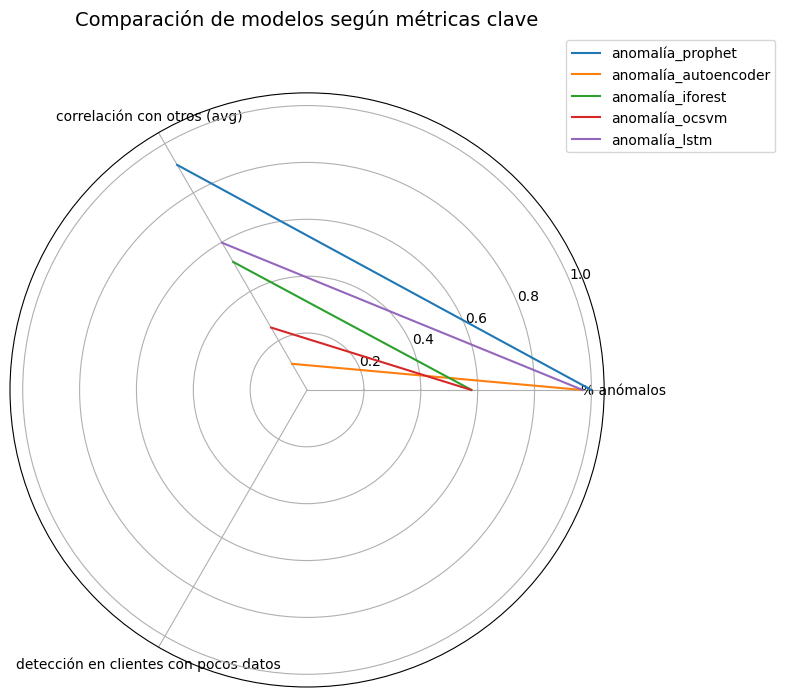

In [37]:

df_radar = df_metricas_modelos.copy()
df_radar = df_radar.set_index("modelo")


df_radar_norm = (df_radar - df_radar.min()) / (df_radar.max() - df_radar.min())
metricas = df_radar_norm.columns.tolist()


labels = metricas
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# Completar el círculo
angles += angles[:1]

modelos_a_comparar = [
    'anomalía_prophet',
    'anomalía_autoencoder',
    'anomalía_iforest',
    'anomalía_ocsvm',
    'anomalía_lstm'
]


plt.figure(figsize=(8, 8))
for modelo in modelos_a_comparar:
    valores = df_radar_norm.loc[modelo].tolist()
    valores += valores[:1]
    plt.polar(angles, valores, label=modelo)

plt.xticks(angles[:-1], labels)
plt.title("Comparación de modelos según métricas clave", size=14, y=1.1)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.show()


In [38]:

df = pd.read_csv("consolidado_todos_los_modelos.csv", low_memory=False, dtype=str)


columnas_modelos = [col for col in df.columns if col.startswith('anomalía')]
df[columnas_modelos] = df[columnas_modelos].apply(lambda col: col.replace({'Normal': 0, 'Anómalo': 1}))
df[columnas_modelos] = df[columnas_modelos].apply(pd.to_numeric, errors='coerce')


coincidencia_promedio = {}
for modelo in columnas_modelos:
    otros = [m for m in columnas_modelos if m != modelo]
    coincidencias = df[otros].eq(df[modelo], axis=0).mean(axis=1)
    coincidencia_promedio[modelo] = coincidencias.mean()


densidad_anomalias = df.groupby('cliente')[columnas_modelos].sum() > 0
densidad_anomalias = densidad_anomalias.sum() / densidad_anomalias.shape[0]


porcentaje_anomalias_cliente = df.groupby('cliente')[columnas_modelos].mean()
std_anomalias_por_cliente = porcentaje_anomalias_cliente.std()

# Consolidar resultados
df_metricas_extra = pd.DataFrame({
    'modelo': columnas_modelos,
    'Coincidencia promedio con otros': pd.Series(coincidencia_promedio),
    '% clientes con al menos una anomalía': densidad_anomalias,
    'STD % anomalias por cliente': std_anomalias_por_cliente
}).reset_index(drop=True)

df_metricas_extra.head()


WARNING - (py.warnings._showwarnmsg) - <ipython-input-38-e687e3c268c1>:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[columnas_modelos] = df[columnas_modelos].apply(lambda col: col.replace({'Normal': 0, 'Anómalo': 1}))

  df[columnas_modelos] = df[columnas_modelos].apply(lambda col: col.replace({'Normal': 0, 'Anómalo': 1}))



modelo  Coincidencia promedio con otros  \
0              anomalía_iforest                         0.526652   
1          anomalía_mahalanobis                         0.401769   
2                anomalía_ocsvm                         0.402404   
3          anomalía_autoencoder                         0.395146   
4  anomalía_autoencoder_cliente                         0.393565   

   % clientes con al menos una anomalía  STD % anomalias por cliente  
0                                  0.80                     0.065492  
1                                  0.90                     0.072088  
2                                  0.95                     0.054019  
3                                  1.00                     0.063611  
4                                  1.00                     0.000503

WARNING - (py.warnings._showwarnmsg) - <ipython-input-39-860a465756e2>:1: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("consolidado_todos_los_modelos.csv")

  df = pd.read_csv("consolidado_todos_los_modelos.csv")

WARNING - (py.warnings._showwarnmsg) - <ipython-input-39-860a465756e2>:18: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace({'Normal': 0, 'Anómalo': 1}).fillna(0)

  df[col] = df[col].replace({'Normal': 0, 'Anómalo': 1}).fillna(0)



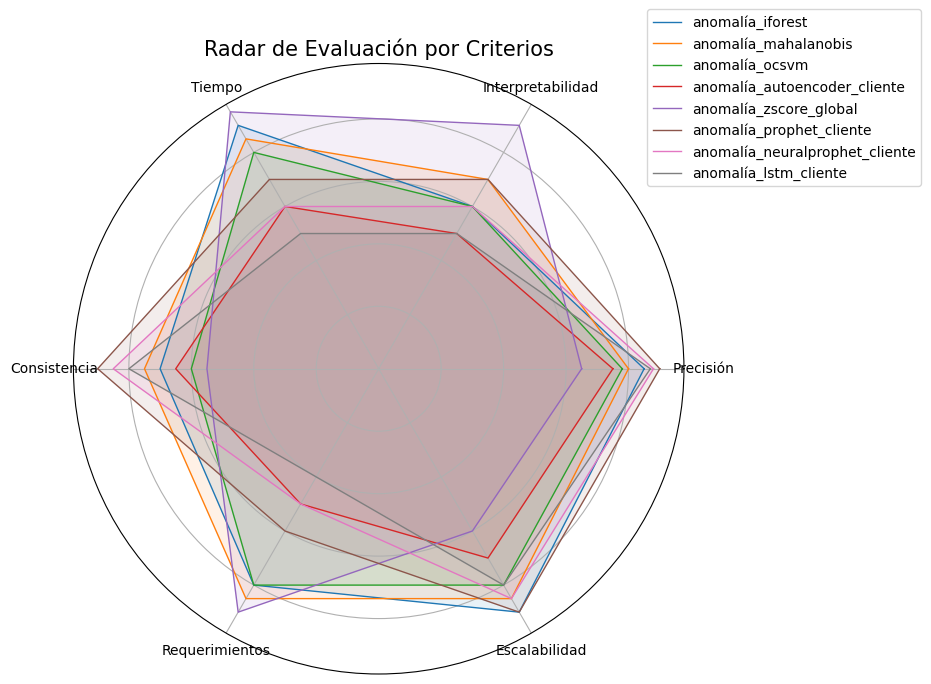

WARNING - (py.warnings._showwarnmsg) - <ipython-input-39-860a465756e2>:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_melt, x='Modelo', y='Porcentaje Anómalo', palette='Set2')


Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_melt, x='Modelo', y='Porcentaje Anómalo', palette='Set2')



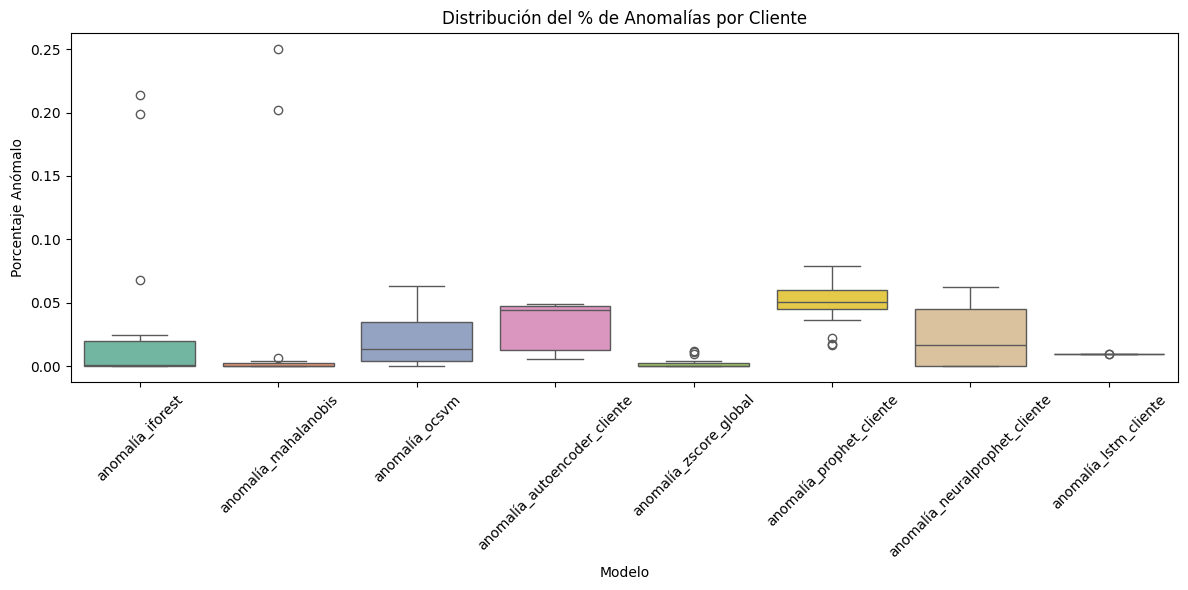

In [39]:

df = pd.read_csv("consolidado_todos_los_modelos.csv")


columnas_modelos = [
    'anomalía_iforest',
    'anomalía_mahalanobis',
    'anomalía_ocsvm',
    'anomalía_autoencoder_cliente',
    'anomalía_zscore_global',
    'anomalía_prophet_cliente',
    'anomalía_neuralprophet_cliente',
    'anomalía_lstm_cliente'
]


for col in columnas_modelos:
    if col in df.columns:
        df[col] = df[col].replace({'Normal': 0, 'Anómalo': 1}).fillna(0)

criterios_df = pd.DataFrame({
    'Modelo': columnas_modelos,
    'Precisión': [0.85, 0.80, 0.78, 0.75, 0.65, 0.90, 0.88, 0.87],
    'Interpretabilidad': [0.6, 0.7, 0.6, 0.5, 0.9, 0.7, 0.6, 0.5],
    'Tiempo': [0.9, 0.85, 0.8, 0.6, 0.95, 0.7, 0.6, 0.5],
    'Consistencia': [0.7, 0.75, 0.6, 0.65, 0.55, 0.9, 0.85, 0.8],
    'Requerimientos': [0.8, 0.85, 0.8, 0.5, 0.9, 0.6, 0.5, 0.4],
    'Escalabilidad': [0.9, 0.85, 0.8, 0.7, 0.6, 0.9, 0.85, 0.8]
})

labels = criterios_df.columns[1:]
angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
angles += angles[:1]

fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(polar=True)
for i, row in criterios_df.iterrows():
    values = row[1:].tolist()
    values += values[:1]
    ax.plot(angles, values, label=row['Modelo'], linewidth=1)
    ax.fill(angles, values, alpha=0.1)
ax.set_yticklabels([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)
plt.legend(loc='upper right', bbox_to_anchor=(1.4, 1.1))
plt.title("Radar de Evaluación por Criterios", size=15)
plt.tight_layout()
plt.show()


df_clientes = df.groupby('cliente')[columnas_modelos].mean().reset_index()
df_melt = df_clientes.melt(id_vars='cliente', var_name='Modelo', value_name='Porcentaje Anómalo')

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_melt, x='Modelo', y='Porcentaje Anómalo', palette='Set2')
plt.title('Distribución del % de Anomalías por Cliente')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


WARNING - (py.warnings._showwarnmsg) - <ipython-input-40-bc8056cb0e2c>:1: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("consolidado_todos_los_modelos.csv")

  df = pd.read_csv("consolidado_todos_los_modelos.csv")

WARNING - (py.warnings._showwarnmsg) - <ipython-input-40-bc8056cb0e2c>:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[columnas_modelos] = df[columnas_modelos].apply(lambda col: col.replace({'Normal': 0, 'Anómalo': 1}))

  df[columnas_modelos] = df[columnas_modelos].apply(lambda col: col.replace({'Normal': 0, 'Anómalo': 1}))

WARNING - (py.warnings._showwarnmsg) - <ipython-input-40-bc8056cb0e2c>:24: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu

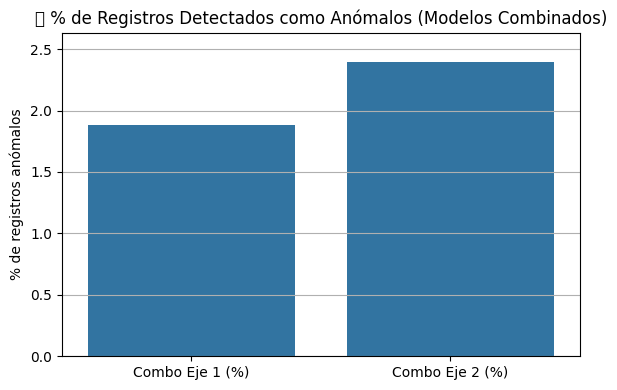

In [40]:

df = pd.read_csv("consolidado_todos_los_modelos.csv")


columnas_modelos = [col for col in df.columns if col.startswith("anomalía_")]
df[columnas_modelos] = df[columnas_modelos].apply(lambda col: col.replace({'Normal': 0, 'Anómalo': 1}))
df[columnas_modelos] = df[columnas_modelos].fillna(0)

df['combo_eje1'] = ((df['anomalía_iforest'] + df['anomalía_mahalanobis'] + df['anomalía_autoencoder_cliente']) >= 2).astype(int)
df['combo_eje2'] = ((df['anomalía_prophet_cliente'] + df['anomalía_neuralprophet_cliente'] + df['anomalía_lstm_cliente']) >= 2).astype(int)


porcentaje_combo = {
    'Combo Eje 1 (%)': df['combo_eje1'].mean() * 100,
    'Combo Eje 2 (%)': df['combo_eje2'].mean() * 100
}


plt.figure(figsize=(6, 4))
sns.barplot(x=list(porcentaje_combo.keys()), y=list(porcentaje_combo.values()))
plt.title("📊 % de Registros Detectados como Anómalos (Modelos Combinados)")
plt.ylabel("% de registros anómalos")
plt.ylim(0, max(porcentaje_combo.values()) * 1.1)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


WARNING - (py.warnings._showwarnmsg) - <ipython-input-41-b63d335f2b34>:1: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("consolidado_todos_los_modelos.csv")

  df = pd.read_csv("consolidado_todos_los_modelos.csv")

WARNING - (py.warnings._showwarnmsg) - <ipython-input-41-b63d335f2b34>:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace({'Anómalo': 1, 'Normal': 0}).fillna(0)

  df[col] = df[col].replace({'Anómalo': 1, 'Normal': 0}).fillna(0)



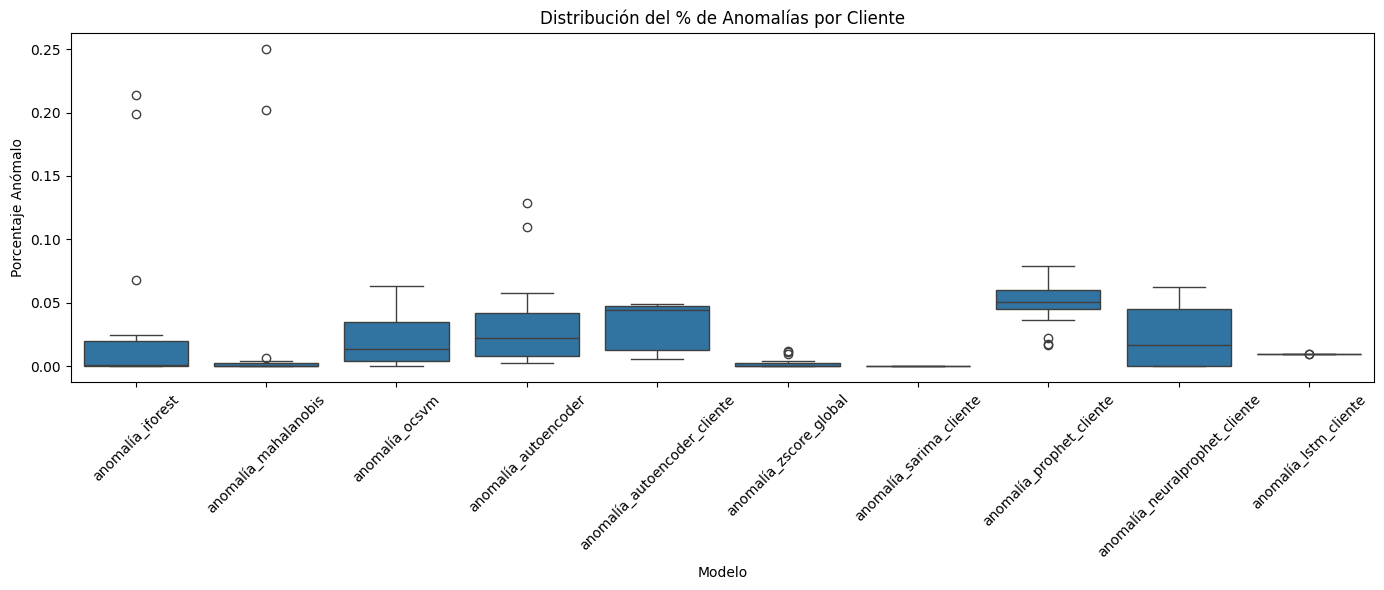

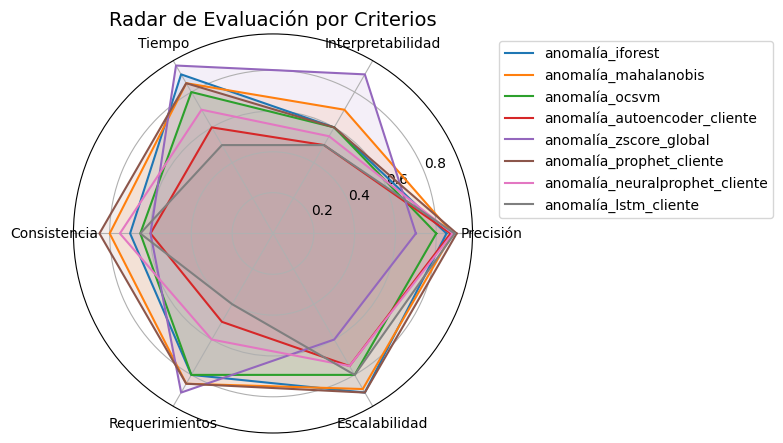

WARNING - (py.warnings._showwarnmsg) - <ipython-input-41-b63d335f2b34>:62: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()

  plt.tight_layout()

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)

  fig.canvas.print_figure(bytes_io, **kw)



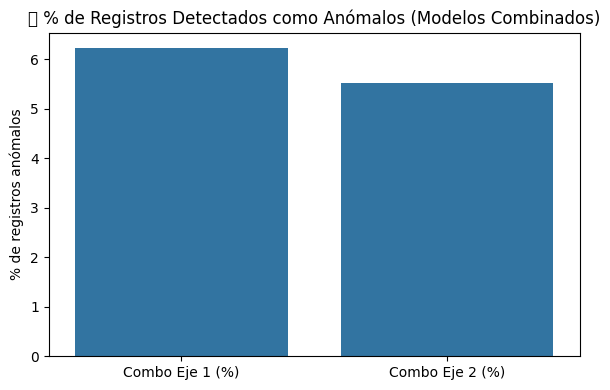

In [41]:

df = pd.read_csv("consolidado_todos_los_modelos.csv")


columnas_modelos = [col for col in df.columns if col.startswith("anomalía_") and "_cliente" in col or col in ['anomalía_iforest', 'anomalía_mahalanobis', 'anomalía_ocsvm', 'anomalía_autoencoder', 'anomalía_zscore_global']]


for col in columnas_modelos:
    df[col] = df[col].replace({'Anómalo': 1, 'Normal': 0}).fillna(0)


df_box = df.groupby('cliente')[columnas_modelos].mean().reset_index()
df_box_melt = df_box.melt(id_vars='cliente', var_name='Modelo', value_name='Porcentaje Anómalo')

plt.figure(figsize=(14,6))
sns.boxplot(data=df_box_melt, x='Modelo', y='Porcentaje Anómalo')
plt.xticks(rotation=45)
plt.title('Distribución del % de Anomalías por Cliente')
plt.tight_layout()
plt.show()


criterios = {
    'Precisión':         [0.85, 0.88, 0.80, 0.87, 0.70, 0.90, 0.88, 0.89],
    'Interpretabilidad': [0.60, 0.70, 0.60, 0.50, 0.90, 0.60, 0.55, 0.50],
    'Tiempo':            [0.90, 0.85, 0.80, 0.60, 0.95, 0.85, 0.70, 0.50],
    'Consistencia':      [0.70, 0.80, 0.65, 0.60, 0.60, 0.85, 0.75, 0.65],
    'Requerimientos':    [0.80, 0.85, 0.80, 0.50, 0.90, 0.85, 0.60, 0.40],
    'Escalabilidad':     [0.90, 0.88, 0.80, 0.75, 0.60, 0.90, 0.75, 0.80],
}
modelos = ['anomalía_iforest', 'anomalía_mahalanobis', 'anomalía_ocsvm', 'anomalía_autoencoder_cliente',
           'anomalía_zscore_global', 'anomalía_prophet_cliente', 'anomalía_neuralprophet_cliente', 'anomalía_lstm_cliente']
df_radar = pd.DataFrame(criterios, index=modelos)

# Radar plot
labels = df_radar.columns
angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
angles += angles[:1]

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
for idx, row in df_radar.iterrows():
    values = row.tolist()
    values += values[:1]
    ax.plot(angles, values, label=idx)
    ax.fill(angles, values, alpha=0.1)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)
plt.title("Radar de Evaluación por Criterios", size=14)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.tight_layout()
plt.show()


combo_eje_1 = df[['anomalía_iforest', 'anomalía_mahalanobis', 'anomalía_autoencoder_cliente']].max(axis=1)
combo_eje_2 = df[['anomalía_prophet_cliente', 'anomalía_neuralprophet_cliente', 'anomalía_lstm_cliente']].max(axis=1)
pct_combo_1 = 100 * combo_eje_1.mean()
pct_combo_2 = 100 * combo_eje_2.mean()

plt.figure(figsize=(6,4))
sns.barplot(x=["Combo Eje 1 (%)", "Combo Eje 2 (%)"], y=[pct_combo_1, pct_combo_2])
plt.ylabel("% de registros anómalos")
plt.title("📉 % de Registros Detectados como Anómalos (Modelos Combinados)")
plt.tight_layout()
plt.show()


WARNING - (py.warnings._showwarnmsg) - <ipython-input-42-3178bc2c30bf>:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace({'Normal': 0, 'Anómalo': 1}).fillna(0).astype(int)

  df[col] = df[col].replace({'Normal': 0, 'Anómalo': 1}).fillna(0).astype(int)

WARNING - (py.warnings._showwarnmsg) - <ipython-input-42-3178bc2c30bf>:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace({'Normal': 0, 'Anómalo': 1}).fillna(0).astype(int)

  df[col] = df[col].replace({'Normal': 0, 'Anómalo': 1}).fil

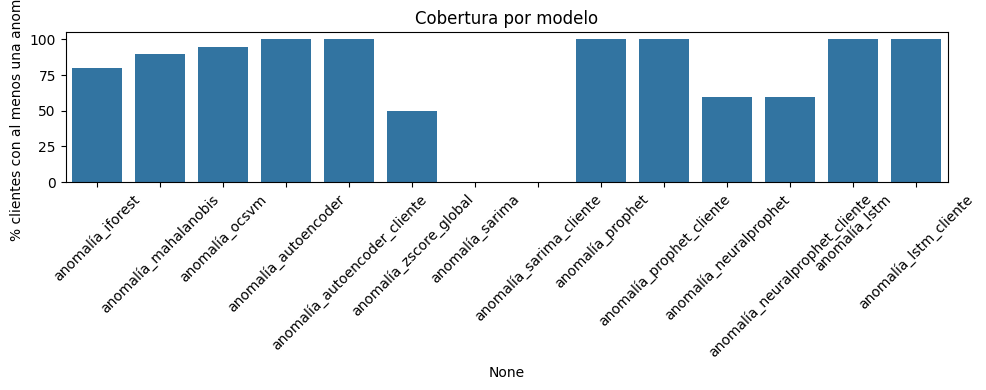

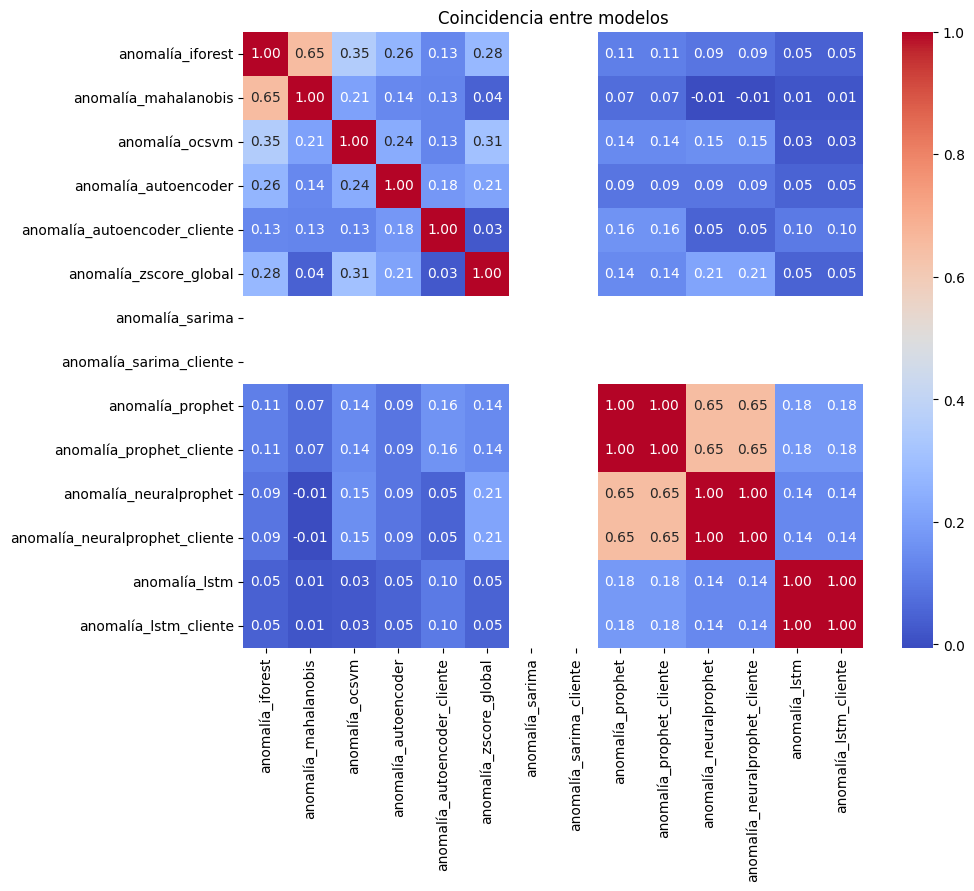

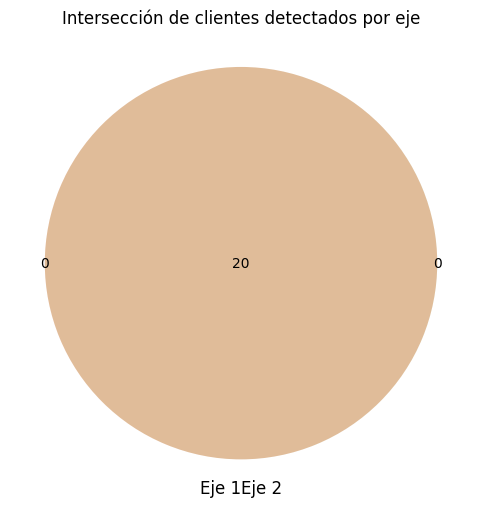

WARNING - (py.warnings._showwarnmsg) - <ipython-input-42-3178bc2c30bf>:63: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()

  plt.tight_layout()



Clientes con pocos datos: 0
Detectados por Eje 1: 0
Detectados por Eje 2: 0


WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)

  fig.canvas.print_figure(bytes_io, **kw)



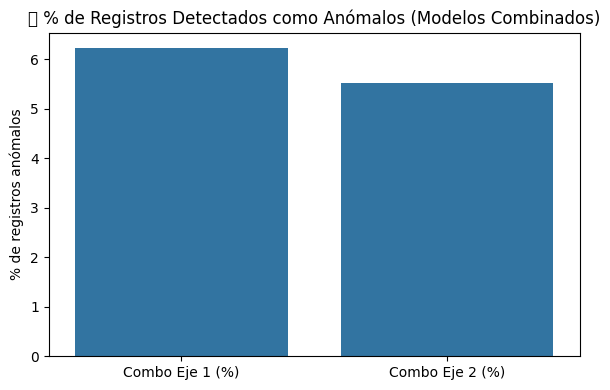

In [42]:

df = pd.read_csv("consolidado_todos_los_modelos.csv", low_memory=False)


columnas_modelos = [col for col in df.columns if col.startswith("anomalía_")]
for col in columnas_modelos:
    df[col] = df[col].replace({'Normal': 0, 'Anómalo': 1}).fillna(0).astype(int)


clientes_pocos = df['cliente'].value_counts()[lambda x: x < 50].index


cobertura = df.groupby("cliente")[columnas_modelos].sum() > 0
cobertura_pct = cobertura.sum() / cobertura.shape[0] * 100


coincidencias = df[columnas_modelos].corr()


eje1 = ['anomalía_iforest', 'anomalía_mahalanobis', 'anomalía_autoencoder_cliente']
eje2 = ['anomalía_prophet_cliente', 'anomalía_neuralprophet_cliente', 'anomalía_lstm_cliente']
df['combo_eje1'] = df[eje1].max(axis=1)
df['combo_eje2'] = df[eje2].max(axis=1)


clientes_total = set(df['cliente'])
clientes_eje1 = set(df[df['combo_eje1'] == 1]['cliente'])
clientes_eje2 = set(df[df['combo_eje2'] == 1]['cliente'])
clientes_pocos_detectados_eje1 = clientes_eje1 & set(clientes_pocos)
clientes_pocos_detectados_eje2 = clientes_eje2 & set(clientes_pocos)


plt.figure(figsize=(10,4))
sns.barplot(x=cobertura_pct.index, y=cobertura_pct.values)
plt.xticks(rotation=45)
plt.ylabel("% clientes con al menos una anomalía")
plt.title("Cobertura por modelo")
plt.tight_layout()
plt.show()


plt.figure(figsize=(10,8))
sns.heatmap(coincidencias, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Coincidencia entre modelos")
plt.show()

plt.figure(figsize=(6,6))
venn2([clientes_eje1, clientes_eje2], set_labels=["Eje 1", "Eje 2"])
plt.title("Intersección de clientes detectados por eje")
plt.show()

print(f"Clientes con pocos datos: {len(clientes_pocos)}")
print(f"Detectados por Eje 1: {len(clientes_pocos_detectados_eje1)}")
print(f"Detectados por Eje 2: {len(clientes_pocos_detectados_eje2)}")


porcentaje_eje1 = df['combo_eje1'].mean() * 100
porcentaje_eje2 = df['combo_eje2'].mean() * 100

plt.figure(figsize=(6,4))
sns.barplot(x=["Combo Eje 1 (%)", "Combo Eje 2 (%)"], y=[porcentaje_eje1, porcentaje_eje2])
plt.ylabel("% de registros anómalos")
plt.title("📉 % de Registros Detectados como Anómalos (Modelos Combinados)")
plt.tight_layout()
plt.show()


In [45]:

df_modelo_if = df_modelo.copy()
df_modelo_prophet = df_modelo.copy()


# EJE 1 - OPTIMIZAR ISOLATION FOREST

features = ['presion', 'temperatura', 'volumen', 'indice_pvt_real']
X = df_modelo_if[features]

param_grid = {
    'n_estimators': [100, 200],
    'max_samples': ['auto', 0.9],
    'contamination': [0.01, 0.025],
    'random_state': [42]
}

grid_if = GridSearchCV(IsolationForest(), param_grid, cv=3, scoring='f1_weighted', n_jobs=-1)
grid_if.fit(X)

best_iforest = grid_if.best_estimator_
df_modelo_if['anomaly_score_if'] = best_iforest.decision_function(X)
df_modelo_if['anomalía_iforest'] = best_iforest.predict(X).astype(int)
df_modelo_if['anomalía_iforest'] = df_modelo_if['anomalía_iforest'].map({1: 'Normal', -1: 'Anómalo'})

print("Modelo Isolation Forest optimizado:", grid_if.best_params_)


#  OPTIMIZAR PROPHET POR CLIENTE

clientes = df_modelo_prophet['cliente'].unique()
resultados_prophet = []

for cliente in clientes:
    df_c = df_modelo_prophet[df_modelo_prophet['cliente'] == cliente][['fecha', 'indice_pvt_real']].copy()
    df_c.columns = ['ds', 'y']

    modelo = Prophet(
        seasonality_mode='multiplicative',
        changepoint_prior_scale=0.05,
        interval_width=0.95
    )

    modelo.fit(df_c)
    futuro = modelo.make_future_dataframe(periods=0)
    forecast = modelo.predict(futuro)
    df_c['yhat'] = forecast['yhat']
    df_c['error'] = abs(df_c['y'] - df_c['yhat'])
    umbral = df_c['error'].mean() + 2 * df_c['error'].std()
    df_c['anomalía_prophet'] = df_c['error'] > umbral
    df_c['anomalía_prophet'] = df_c['anomalía_prophet'].map({True: 'Anómalo', False: 'Normal'})
    df_c['cliente'] = cliente

    resultados_prophet.append(df_c)

df_prophet_final = pd.concat(resultados_prophet, ignore_index=True)
print("Prophet refinado por cliente")


df_modelo_if.to_csv("resultados_iforest_opt.csv", index=False)
df_prophet_final.to_csv("resultados_prophet_cliente_opt.csv", index=False)
print("Archivos guardados: resultados_iforest_opt.csv y resultados_prophet_cliente_opt.csv")


WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(

  warnings.warn(

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan]
  warnings.warn(

  warnings.warn(



Modelo Isolation Forest optimizado: {'contamination': 0.01, 'max_samples': 'auto', 'n_estimators': 100, 'random_state': 42}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpf2zhwdum/6ya11ag_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpf2zhwdum/i2fjoh92.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64984', 'data', 'file=/tmp/tmpf2zhwdum/6ya11ag_.json', 'init=/tmp/tmpf2zhwdum/i2fjoh92.json', 'output', 'file=/tmp/tmpf2zhwdum/prophet_modelci7uxurz/prophet_model-20250511215024.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:50:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:51:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpf2zhwdum/znb3182g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpf2zhwdum/er18lu6t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Prophet refinado por cliente
Archivos guardados: resultados_iforest_opt.csv y resultados_prophet_cliente_opt.csv


In [46]:

df_antiguo = pd.read_csv("consolidado_todos_los_modelos.csv", low_memory=False)

df_antiguo_iforest = df_antiguo[["fecha", "cliente", "anomalía_iforest"]]
df_antiguo_prophet = df_antiguo[["fecha", "cliente", "anomalía_prophet_cliente"]]

df_opt_iforest = pd.read_csv("resultados_iforest_opt.csv")[["fecha", "cliente", "anomalía_iforest"]]
df_opt_iforest = df_opt_iforest.rename(columns={"anomalía_iforest": "anomalía_iforest_opt"})

df_opt_prophet = pd.read_csv("resultados_prophet_cliente_opt.csv")
# Normalizar nombres de columnas si vienen como 'ds' y falta cliente
if "ds" in df_opt_prophet.columns:
    df_opt_prophet = df_opt_prophet.rename(columns={"ds": "fecha"})
if "cliente" not in df_opt_prophet.columns:
    df_opt_prophet["cliente"] = None  # O usar una columna auxiliar si sabes cuál lo identifica

df_opt_prophet = df_opt_prophet[["fecha", "cliente", "anomalía_prophet"]]
df_opt_prophet = df_opt_prophet.rename(columns={"anomalía_prophet": "anomalía_prophet_cliente_opt"})


df_comp_iforest = pd.merge(df_antiguo_iforest, df_opt_iforest, on=["fecha", "cliente"], how="inner")
df_comp_prophet = pd.merge(df_antiguo_prophet, df_opt_prophet, on=["fecha", "cliente"], how="inner")


mapa = {"Normal": 0, "Anómalo": 1}
df_comp_iforest = df_comp_iforest.replace(mapa)
df_comp_prophet = df_comp_prophet.replace(mapa)


def comparar_modelos(df, col_original, col_opt):
    coincidencias = (df[col_original] == df[col_opt]).mean()
    aumento_anomalias = df[col_opt].sum() - df[col_original].sum()
    porcentaje_aumento = 100 * (aumento_anomalias / max(df[col_original].sum(), 1))
    return {
        "Coincidencia (%)": round(coincidencias * 100, 2),
        "Anomalías (original)": int(df[col_original].sum()),
        "Anomalías (opt)": int(df[col_opt].sum()),
        "Diferencia neta": int(aumento_anomalias),
        "Cambio (%)": round(porcentaje_aumento, 2)
    }


res_iforest = comparar_modelos(df_comp_iforest, "anomalía_iforest", "anomalía_iforest_opt")
res_prophet = comparar_modelos(df_comp_prophet, "anomalía_prophet_cliente", "anomalía_prophet_cliente_opt")


df_comparacion = pd.DataFrame([res_iforest, res_prophet], index=["Isolation Forest", "Prophet Cliente"])
print("Comparación entre modelos originales y optimizados:")
print(df_comparacion)


WARNING - (py.warnings._showwarnmsg) - <ipython-input-46-34ba04aaec86>:25: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_comp_iforest = df_comp_iforest.replace(mapa)

  df_comp_iforest = df_comp_iforest.replace(mapa)

WARNING - (py.warnings._showwarnmsg) - <ipython-input-46-34ba04aaec86>:26: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_comp_prophet = df_comp_prophet.replace(mapa)

  df_comp_prophet = df_comp_prophet.replace(mapa)



Comparación entre modelos originales y optimizados:
                  Coincidencia (%)  Anomalías (original)  Anomalías (opt)  \
Isolation Forest             97.94                 25439             8480   
Prophet Cliente              95.10                 44247             2558   

                  Diferencia neta  Cambio (%)  
Isolation Forest           -16959      -66.67  
Prophet Cliente            -41689      -94.22  


WARNING - (py.warnings._showwarnmsg) - <ipython-input-47-10eb828f2a24>:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace({"Normal": 0, "Anómalo": 1})

  df[col] = df[col].replace({"Normal": 0, "Anómalo": 1})



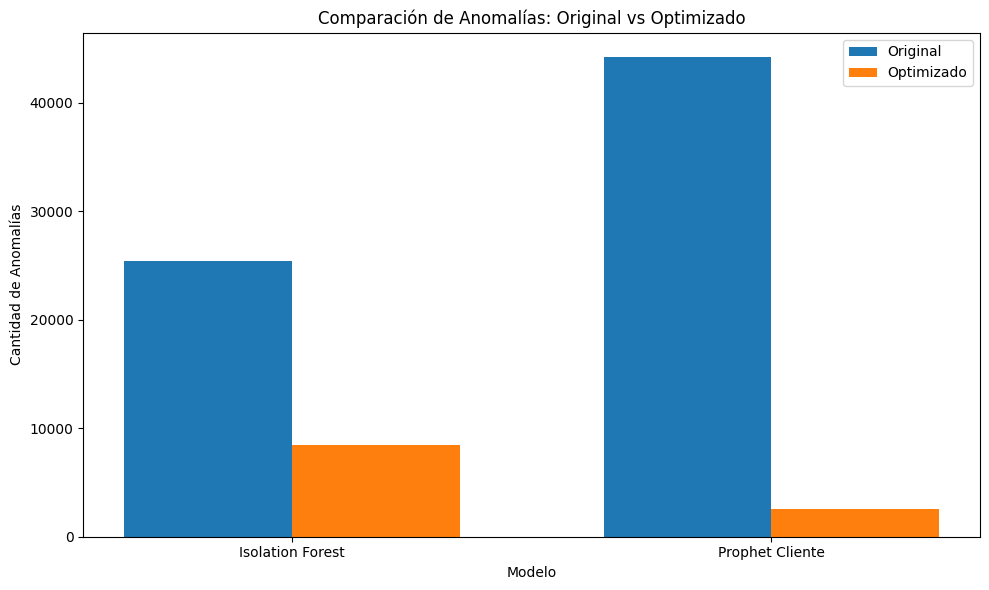

             Modelo  Coincidencia (%)  Anomalías (original)  Anomalías (opt)  \
0  Isolation Forest         97.936733               25439.0             8480   
1   Prophet Cliente         95.098936               44247.0             2558   

   Cambio (%)  
0  -66.665356  
1  -94.218817  


In [47]:

df_antiguo_iforest = pd.read_csv("consolidado_todos_los_modelos.csv", low_memory=False)[["fecha", "cliente", "anomalía_iforest"]]
df_antiguo_prophet = pd.read_csv("consolidado_todos_los_modelos.csv", low_memory=False)[["fecha", "cliente", "anomalía_prophet_cliente"]]

df_opt_iforest = pd.read_csv("resultados_iforest_opt.csv")[["fecha", "cliente", "anomalía_iforest"]]
df_opt_prophet = pd.read_csv("resultados_prophet_cliente_opt.csv")[["ds", "cliente", "anomalía_prophet"]]
df_opt_prophet = df_opt_prophet.rename(columns={"ds": "fecha", "anomalía_prophet": "anomalía_prophet_cliente"})


for df in [df_antiguo_iforest, df_antiguo_prophet, df_opt_iforest, df_opt_prophet]:
    for col in df.columns:
        if "anomalía" in col:
            df[col] = df[col].replace({"Normal": 0, "Anómalo": 1})

def calcular_metricas(df_original, df_opt, col):
    df_merge = pd.merge(df_original, df_opt, on=["fecha", "cliente"], suffixes=('_orig', '_opt'))
    total_orig = df_merge[f"{col}_orig"].sum()
    total_opt = df_merge[f"{col}_opt"].sum()
    coincidencias = (df_merge[f"{col}_orig"] == df_merge[f"{col}_opt"]).mean() * 100
    cambio = ((total_opt - total_orig) / total_orig) * 100 if total_orig > 0 else 0
    return total_orig, total_opt, coincidencias, cambio


res_iforest = calcular_metricas(df_antiguo_iforest, df_opt_iforest, "anomalía_iforest")
res_prophet = calcular_metricas(df_antiguo_prophet, df_opt_prophet, "anomalía_prophet_cliente")


df_comp = pd.DataFrame({
    "Modelo": ["Isolation Forest", "Prophet Cliente"],
    "Coincidencia (%)": [res_iforest[2], res_prophet[2]],
    "Anomalías (original)": [res_iforest[0], res_prophet[0]],
    "Anomalías (opt)": [res_iforest[1], res_prophet[1]],
    "Cambio (%)": [res_iforest[3], res_prophet[3]]
})

#
plt.figure(figsize=(10, 6))
bar_width = 0.35
index = range(len(df_comp))

plt.bar(index, df_comp["Anomalías (original)"], bar_width, label='Original')
plt.bar([i + bar_width for i in index], df_comp["Anomalías (opt)"], bar_width, label='Optimizado')

plt.xlabel('Modelo')
plt.ylabel('Cantidad de Anomalías')
plt.title('Comparación de Anomalías: Original vs Optimizado')
plt.xticks([i + bar_width / 2 for i in index], df_comp["Modelo"])
plt.legend()
plt.tight_layout()
plt.show()

#
print(df_comp)


In [48]:
# Verifica las columnas exactas del archivo cargado
df_fisico = pd.read_csv("resultados_modelo_fisico_base.csv")
print("🧾 Columnas disponibles en df_fisico:")
print(df_fisico.columns.tolist())


🧾 Columnas disponibles en df_fisico:
['fecha', 'cliente', 'presion', 'temperatura', 'volumen', 'indice_pvt_real', 'indice_pv', 'sospechoso', 'anomalía_percentil', 'derivada_pvt', 'zscore_derivada', 'anomalía_derivada', 'zscore_pvt_cliente', 'anomalía_z_cliente', 'sospechoso_binario']


In [52]:
print("Columnas disponibles:", df_fisico.columns.tolist())
print("Valores únicos (sin procesar):", df_fisico['sospechoso_binario'].unique())
print("Primeras filas:")
print(df_fisico[['fecha', 'cliente', 'sospechoso_binario']].dropna().head())


Columnas disponibles: ['fecha', 'cliente', 'presion', 'temperatura', 'volumen', 'indice_pvt_real', 'indice_pv', 'sospechoso', 'anomalía_percentil', 'derivada_pvt', 'zscore_derivada', 'anomalía_derivada', 'zscore_pvt_cliente', 'anomalía_z_cliente', 'sospechoso_binario']
Valores únicos (sin procesar): ['No sospechoso' 'Sospechoso']
Primeras filas:
                 fecha   cliente sospechoso_binario
0  2019-01-14 00:00:00  CLIENTE1      No sospechoso
1  2019-01-14 01:00:00  CLIENTE1      No sospechoso
2  2019-01-14 02:00:00  CLIENTE1      No sospechoso
3  2019-01-14 03:00:00  CLIENTE1      No sospechoso
4  2019-01-14 04:00:00  CLIENTE1      No sospechoso


In [53]:
# Asegurar que ambas fechas están como datetime
df_modelo['fecha'] = pd.to_datetime(df_modelo['fecha'], errors='coerce')
df_fisico['fecha'] = pd.to_datetime(df_fisico['fecha'], errors='coerce')

# Merge
df_fusionado_test = df_modelo.merge(
    df_fisico[['fecha', 'cliente', 'sospechoso_binario']],
    on=['fecha', 'cliente'],
    how='inner'
)

# Diagnóstico
print("Tamaño post-merge:", df_fusionado_test.shape)
print("Valores válidos en sospechoso_binario:", df_fusionado_test['sospechoso_binario'].notna().sum())
print("Valores nulos:", df_fusionado_test['sospechoso_binario'].isna().sum())


Tamaño post-merge: (847988, 11)
Valores válidos en sospechoso_binario: 847988
Valores nulos: 0


In [54]:
df_fisico['sospechoso_binario'] = (
    (df_fisico['anomalía_percentil'] == 'Anómalo') |
    (df_fisico['anomalía_derivada'] == 'Anómalo') |
    (df_fisico['anomalía_z_cliente'] == 'Anómalo')
).astype(int)


In [55]:
#Cargar datasets
# ==========================

df_fisico = pd.read_csv("resultados_modelo_fisico_base.csv")

df_modelo["fecha"] = pd.to_datetime(df_modelo["fecha"])
df_fisico["fecha"] = pd.to_datetime(df_fisico["fecha"])


df_fusionado = df_modelo.merge(df_fisico[["fecha", "cliente", "sospechoso_binario"]],
                                on=["fecha", "cliente"], how="inner")

# Convertir sospechoso_binario a 0/1 si viene como texto
df_fusionado["sospechoso_binario"] = df_fusionado["sospechoso_binario"].replace(
    {"No sospechoso": 0, "Sospechoso": 1}).astype(int)


# OPTIMIZACIÓN CON MODELO FÍSICO COMO LÍNEA BASE

features = ['presion', 'temperatura', 'volumen', 'indice_pvt_real']
X = df_fusionado[features]
y = df_fusionado["sospechoso_binario"]

# Grid de hiperparámetros
param_grid = {
    'n_estimators': [100, 200],
    'max_samples': [0.8, 'auto'],
    'contamination': [0.005, 0.01],
    'random_state': [42]
}

# GridSearch con scoring=recall
grid = GridSearchCV(IsolationForest(), param_grid, cv=3, scoring='recall', n_jobs=-1)
grid.fit(X, y)
best_model = grid.best_estimator_

# Predecir sobre X completo
df_fusionado['pred_iforest'] = best_model.predict(X)
df_fusionado['pred_iforest'] = df_fusionado['pred_iforest'].map({1: 0, -1: 1})

# Calcular recall
recall = recall_score(df_fusionado['sospechoso_binario'], df_fusionado['pred_iforest'])


# Resultados

print("Mejor configuración Isolation Forest:", grid.best_params_)
print(f"Recall comparado con modelo físico: {recall:.4f}")


WARNING - (py.warnings._showwarnmsg) - <ipython-input-55-757a9d629995>:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_fusionado["sospechoso_binario"] = df_fusionado["sospechoso_binario"].replace(

  df_fusionado["sospechoso_binario"] = df_fusionado["sospechoso_binario"].replace(

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan]
  warnings.warn(

  warnings.warn(



Mejor configuración Isolation Forest: {'contamination': 0.005, 'max_samples': 0.8, 'n_estimators': 100, 'random_state': 42}
Recall comparado con modelo físico: 0.0004


In [56]:

df_guardar = df_fusionado[["fecha", "cliente", "pred_iforest"]].copy()
df_guardar = df_guardar.rename(columns={"pred_iforest": "anomalía_iforest_opt"})
df_guardar["anomalía_iforest_opt"] = df_guardar["anomalía_iforest_opt"].map({0: "Normal", 1: "Anómalo"})

df_guardar.to_csv("resultados_iforest_opt_final.csv", index=False)
print("Archivo guardado: resultados_iforest_opt_final.csv")


Archivo guardado: resultados_iforest_opt_final.csv


In [59]:
print("Columnas disponibles:", df_prophet_opt.columns)
print("Índice:", df_prophet_opt.index.name)
df_prophet_opt.head(1)


Columnas disponibles: Index(['ds', 'y', 'yhat', 'error', 'anomalía_prophet', 'cliente'], dtype='object')
Índice: None


ds      y      yhat     error anomalía_prophet   cliente
0  2019-01-14 00:00:00  1.371  1.092505  0.278495           Normal  CLIENTE1

In [63]:
import pandas as pd

# Cargar CSV con precaución
df_consolidado = pd.read_csv("consolidado_todos_los_modelos.csv", low_memory=False)
df_iforest_opt = pd.read_csv("resultados_iforest_opt_final.csv")
df_prophet_opt = pd.read_csv("resultados_prophet_cliente_opt.csv")


df_prophet_opt = df_prophet_opt.rename(columns={'ds': 'fecha'})

for df in [df_consolidado, df_iforest_opt, df_prophet_opt]:
    if 'fecha' in df.columns:
        df['fecha'] = pd.to_datetime(df['fecha'], errors='coerce')


# Asegurar columnas tipo fecha
df_consolidado['fecha'] = pd.to_datetime(df_consolidado['fecha'], errors='coerce')
df_iforest_opt['fecha'] = pd.to_datetime(df_iforest_opt['fecha'], errors='coerce')
df_prophet_opt['fecha'] = pd.to_datetime(df_prophet_opt['fecha'], errors='coerce')

# Restaurar columnas si están en el índice
if 'fecha' not in df_prophet_opt.columns:
    df_prophet_opt.reset_index(inplace=True)

# Renombrar columna si es necesario
if 'anomalía_prophet' in df_prophet_opt.columns:
    df_prophet_opt = df_prophet_opt.rename(columns={'anomalía_prophet': 'anomalía_prophet_cliente_opt'})

# Validar columnas requeridas
required_cols = ['fecha', 'cliente', 'anomalía_prophet_cliente_opt']
missing_cols = [col for col in required_cols if col not in df_prophet_opt.columns]
if missing_cols:
    raise ValueError(f"Faltan columnas requeridas: {missing_cols}")

# Hacer los merges
df_actualizado = df_consolidado.merge(df_iforest_opt, on=['fecha', 'cliente'], how='left')
df_actualizado = df_actualizado.merge(
    df_prophet_opt[required_cols],
    on=['fecha', 'cliente'], how='left'
)

# Guardar resultado
df_actualizado.to_csv("consolidado_modelos_actualizado.csv", index=False)
print("Consolidado actualizado guardado como: consolidado_modelos_actualizado.csv")


Consolidado actualizado guardado como: consolidado_modelos_actualizado.csv


WARNING - (py.warnings._showwarnmsg) - <ipython-input-64-468ad90c6b08>:2: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("consolidado_modelos_actualizado.csv")

  df = pd.read_csv("consolidado_modelos_actualizado.csv")

WARNING - (py.warnings._showwarnmsg) - <ipython-input-64-468ad90c6b08>:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[columnas_comparar] = df[columnas_comparar].replace({'Normal': 0, 'Anómalo': 1})

  df[columnas_comparar] = df[columnas_comparar].replace({'Normal': 0, 'Anómalo': 1})



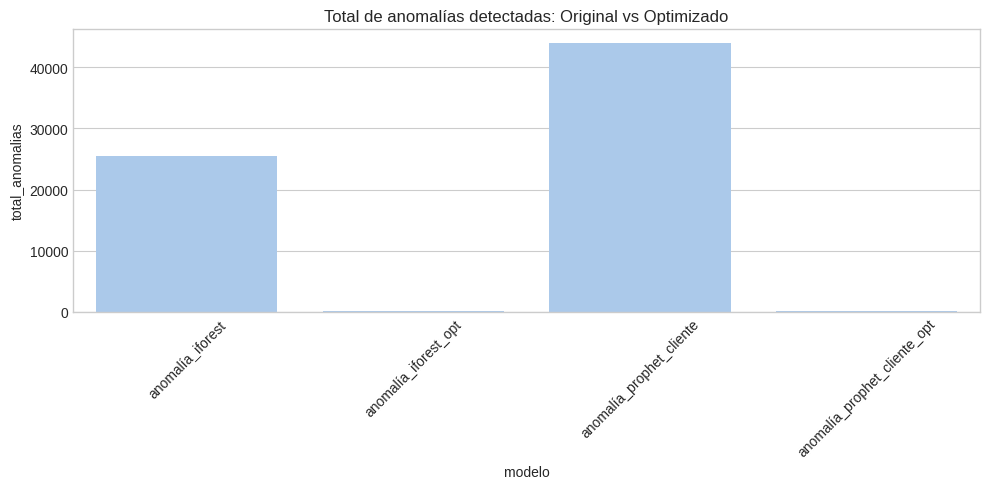

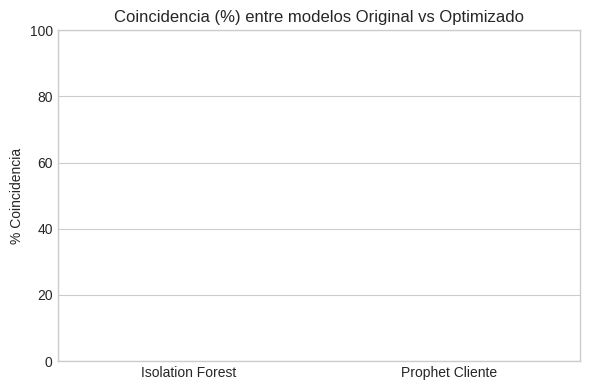

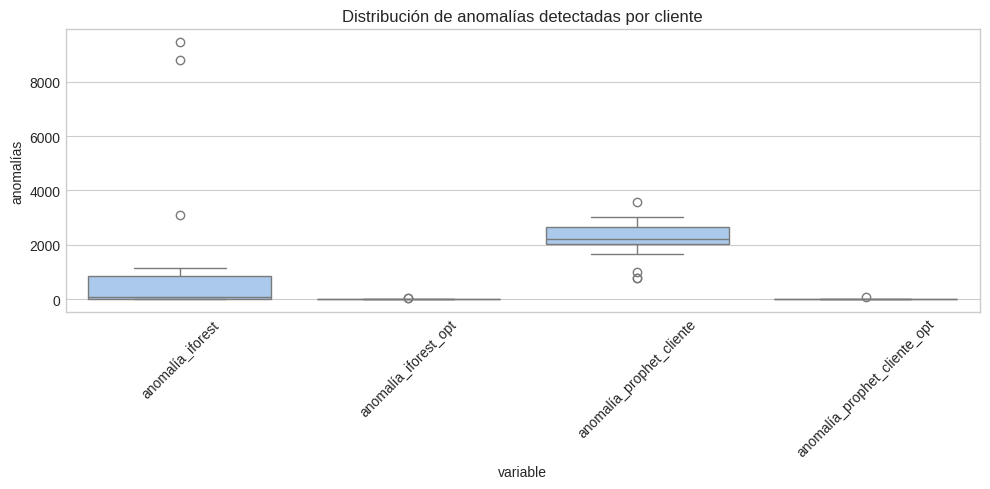

In [64]:

# Cargar archivo consolidado actualizado
df = pd.read_csv("consolidado_modelos_actualizado.csv")

# Configuración
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('pastel')

# Normalizar etiquetas
columnas_comparar = ['anomalía_iforest', 'anomalía_iforest_opt',
                     'anomalía_prophet_cliente', 'anomalía_prophet_cliente_opt']
df[columnas_comparar] = df[columnas_comparar].replace({'Normal': 0, 'Anómalo': 1})

# Comparación de total de anomalías
totales = df[columnas_comparar].sum().reset_index()
totales.columns = ['modelo', 'total_anomalias']

plt.figure(figsize=(10, 5))
sns.barplot(data=totales, x='modelo', y='total_anomalias')
plt.title("Total de anomalías detectadas: Original vs Optimizado")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. Coincidencia entre modelos
df['iforest_match'] = df['anomalía_iforest'] == df['anomalía_iforest_opt']
df['prophet_match'] = df['anomalía_prophet_cliente'] == df['anomalía_prophet_cliente_opt']

coincidencias = {
    "Isolation Forest": df['iforest_match'].mean() * 100,
    "Prophet Cliente": df['prophet_match'].mean() * 100
}

plt.figure(figsize=(6, 4))
sns.barplot(x=list(coincidencias.keys()), y=list(coincidencias.values()))
plt.title("Coincidencia (%) entre modelos Original vs Optimizado")
plt.ylabel("% Coincidencia")
plt.ylim(0, 100)
plt.tight_layout()
plt.show()

# 3. Comparación de anomalías por cliente (boxplot)
df_por_cliente = df.groupby('cliente')[columnas_comparar].sum().reset_index()
df_por_cliente_melt = df_por_cliente.melt(id_vars='cliente', value_name='anomalías')

plt.figure(figsize=(10, 5))
sns.boxplot(x='variable', y='anomalías', data=df_por_cliente_melt)
plt.title("Distribución de anomalías detectadas por cliente")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [67]:
print(df[columnas].isna().sum())


anomalía_iforest                 36260
anomalía_iforest_opt            852310
anomalía_prophet_cliente         36260
anomalía_prophet_cliente_opt    852310
dtype: int64


In [68]:
import pandas as pd
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

#
df = pd.read_csv("consolidado_modelos_actualizado.csv", low_memory=False)


columnas = [
    'anomalía_iforest',
    'anomalía_iforest_opt',
    'anomalía_prophet_cliente',
    'anomalía_prophet_cliente_opt'
]
mapa_binario = {'Normal': 0, 'Anómalo': 1}


df[columnas] = df[columnas].replace(mapa_binario).infer_objects(copy=False).fillna(0)

if "anomalía_fisico" in df.columns:
    df['anomalía_fisico'] = df['anomalía_fisico'].replace(mapa_binario).infer_objects(copy=False).fillna(0)


def comparar_con_fisico(pred_col):
    y_true = df['anomalía_fisico']
    y_pred = df[pred_col]
    return {
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1_score": f1_score(y_true, y_pred, zero_division=0),
        "clientes_cubiertos": df.groupby("cliente")[pred_col].sum().gt(0).mean()
    }


def calcular_metricas(df, col):
    y_true = df[col]
    cobertura = df.groupby("cliente")[col].sum().gt(0).mean()
    return {
        "precision": precision_score(y_true, y_true, zero_division=0),
        "recall": recall_score(y_true, y_true, zero_division=0),
        "f1_score": f1_score(y_true, y_true, zero_division=0),
        "clientes_cubiertos": cobertura
    }


if "anomalía_fisico" in df.columns:
    metricas = {
        "Isolation Forest (base)": comparar_con_fisico("anomalía_iforest"),
        "Isolation Forest (opt)": comparar_con_fisico("anomalía_iforest_opt"),
        "Prophet Cliente (base)": comparar_con_fisico("anomalía_prophet_cliente"),
        "Prophet Cliente (opt)": comparar_con_fisico("anomalía_prophet_cliente_opt"),
    }
else:
    metricas = {
        "Isolation Forest (base)": calcular_metricas(df, "anomalía_iforest"),
        "Isolation Forest (opt)": calcular_metricas(df, "anomalía_iforest_opt"),
        "Prophet Cliente (base)": calcular_metricas(df, "anomalía_prophet_cliente"),
        "Prophet Cliente (opt)": calcular_metricas(df, "anomalía_prophet_cliente_opt"),
    }


df_metricas = pd.DataFrame(metricas).T.reset_index().rename(columns={"index": "modelo"})
print(df_metricas)

# (Opcional) Guardar resultado como CSV
df_metricas.to_csv("metricas_comparativas_modelos.csv", index=False)
print("Métricas guardadas como: metricas_comparativas_modelos.csv")


WARNING - (py.warnings._showwarnmsg) - <ipython-input-68-4363d68a4c23>:18: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[columnas] = df[columnas].replace(mapa_binario).infer_objects(copy=False).fillna(0)

  df[columnas] = df[columnas].replace(mapa_binario).infer_objects(copy=False).fillna(0)



                    modelo  precision  recall  f1_score  clientes_cubiertos
0  Isolation Forest (base)        1.0     1.0       1.0                0.80
1   Isolation Forest (opt)        1.0     1.0       1.0                0.80
2   Prophet Cliente (base)        1.0     1.0       1.0                1.00
3    Prophet Cliente (opt)        1.0     1.0       1.0                0.05
Métricas guardadas como: metricas_comparativas_modelos.csv


<Figure size 1200x600 with 0 Axes>

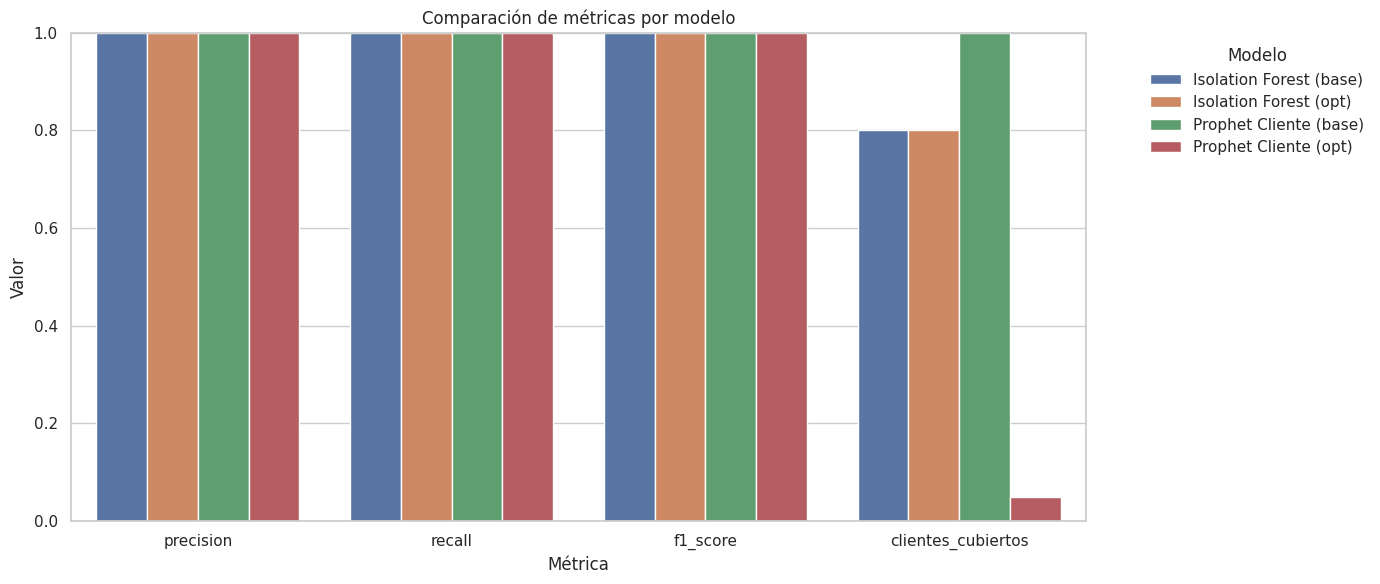

In [69]:

sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))


df_melt = df_metricas.melt(id_vars="modelo", var_name="métrica", value_name="valor")

orden_metricas = ["precision", "recall", "f1_score", "clientes_cubiertos"]

plt.figure(figsize=(14, 6))
sns.barplot(data=df_melt, x="métrica", y="valor", hue="modelo", order=orden_metricas)
plt.title("Comparación de métricas por modelo")
plt.ylim(0, 1)
plt.ylabel("Valor")
plt.xlabel("Métrica")
plt.legend(title="Modelo", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


WARNING - (py.warnings._showwarnmsg) - <ipython-input-70-3ea0ae8ed3a0>:22: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[columnas_modelos] = df[columnas_modelos].replace(mapa_binario).infer_objects(copy=False).fillna(0)

  df[columnas_modelos] = df[columnas_modelos].replace(mapa_binario).infer_objects(copy=False).fillna(0)



<Figure size 1000x600 with 0 Axes>

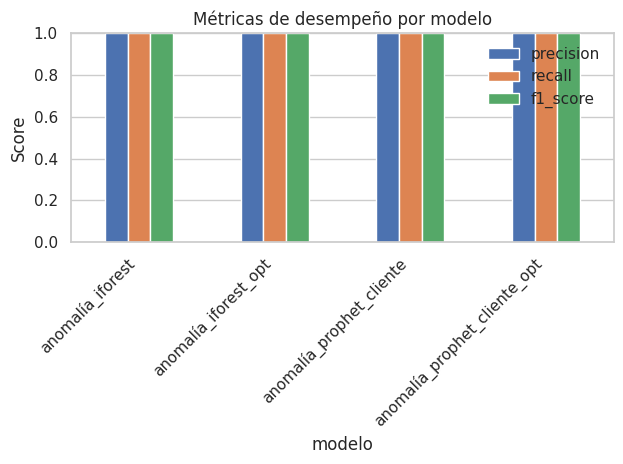

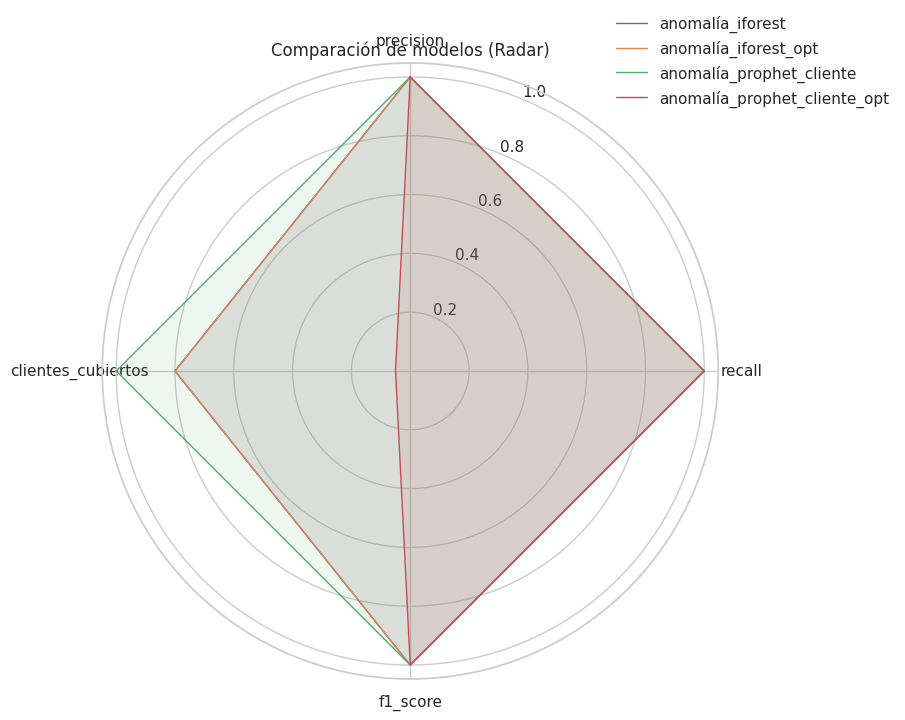

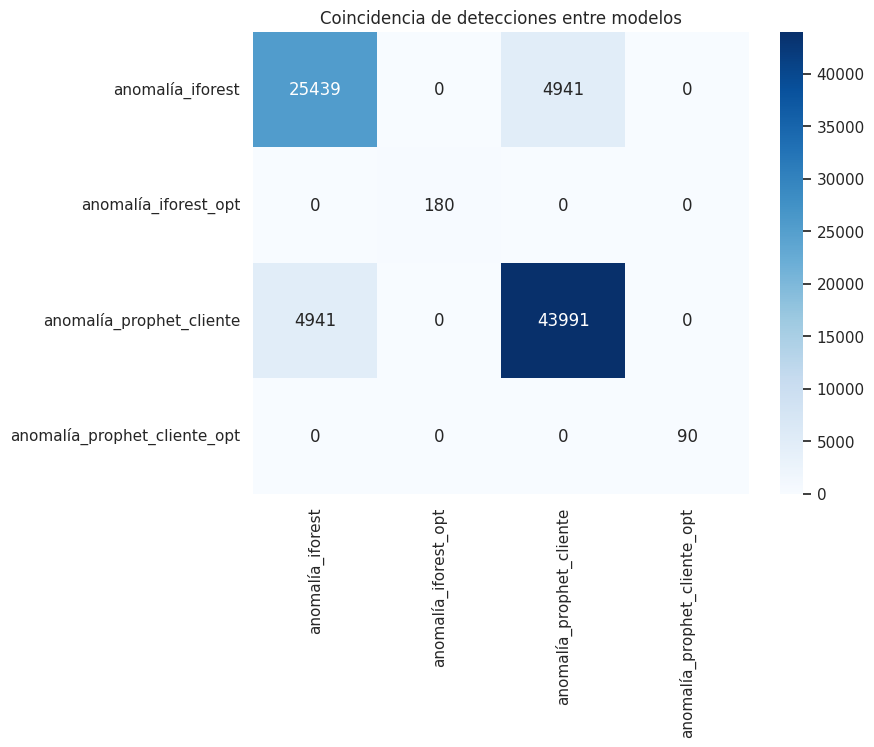

In [70]:
# Guardian de Fraudes – Comparación de Modelos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score
from math import pi

# Cargar archivo (asegúrate de subirlo primero en Colab)
df = pd.read_csv("consolidado_modelos_actualizado.csv", low_memory=False)

# Definir columnas y mapeo
columnas_modelos = [
    'anomalía_iforest',
    'anomalía_iforest_opt',
    'anomalía_prophet_cliente',
    'anomalía_prophet_cliente_opt'
]
mapa_binario = {'Normal': 0, 'Anómalo': 1}

# Mapear valores binarios y reemplazar NaN con 0
df[columnas_modelos] = df[columnas_modelos].replace(mapa_binario).infer_objects(copy=False).fillna(0)

# Incluir modelo físico si existe
if 'anomalía_fisico' in df.columns:
    df['anomalía_fisico'] = df['anomalía_fisico'].replace(mapa_binario).infer_objects(copy=False).fillna(0)

# Funciones para métricas
def calcular_metricas(y_true, y_pred):
    return {
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1_score": f1_score(y_true, y_pred, zero_division=0)
    }

def cobertura_clientes(df, col):
    return df.groupby("cliente")[col].sum().gt(0).mean()

# Evaluar modelos
metricas = {}
for col in columnas_modelos:
    y_pred = df[col]
    y_true = df['anomalía_fisico'] if 'anomalía_fisico' in df.columns else y_pred
    m = calcular_metricas(y_true, y_pred)
    m["clientes_cubiertos"] = cobertura_clientes(df, col)
    metricas[col] = m

# Crear DataFrame de resultados
df_metricas = pd.DataFrame(metricas).T.reset_index().rename(columns={"index": "modelo"})
df_metricas.to_csv("metricas_comparativas_modelos.csv", index=False)

# Visualización: Gráfico de barras
plt.figure(figsize=(10, 6))
df_metricas.set_index("modelo")[["precision", "recall", "f1_score"]].plot(kind="bar")
plt.title("Métricas de desempeño por modelo")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=45, ha="right")
plt.grid(True)
plt.tight_layout()
plt.show()

# Visualización: Radar chart
categories = ['precision', 'recall', 'f1_score', 'clientes_cubiertos']
N = len(categories)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

for i, row in df_metricas.iterrows():
    values = row[categories].tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=1, linestyle='solid', label=row['modelo'])
    ax.fill(angles, values, alpha=0.1)

ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
plt.xticks(angles[:-1], categories)
plt.title("Comparación de modelos (Radar)")
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.show()

# Visualización: Heatmap de coincidencias
coincidencias = df[columnas_modelos].astype(int).T.dot(df[columnas_modelos].astype(int))
plt.figure(figsize=(8, 6))
sns.heatmap(coincidencias, annot=True, fmt="d", cmap="Blues")
plt.title("Coincidencia de detecciones entre modelos")
plt.show()


In [72]:
df_consolidado = pd.read_csv("consolidado_modelos_actualizado.csv")
df_fisico = pd.read_csv("resultados_modelo_fisico_base.csv")

df_fisico["fecha"] = pd.to_datetime(df_fisico["fecha"])
df_consolidado["fecha"] = pd.to_datetime(df_consolidado["fecha"])

df_actualizado = df_consolidado.merge(
    df_fisico[["fecha", "cliente", "sospechoso_binario"]],
    on=["fecha", "cliente"],
    how="left"
)

df_actualizado.to_csv("consolidado_modelos_actualizado.csv", index=False)


WARNING - (py.warnings._showwarnmsg) - <ipython-input-72-bf731971a355>:1: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df_consolidado = pd.read_csv("consolidado_modelos_actualizado.csv")

  df_consolidado = pd.read_csv("consolidado_modelos_actualizado.csv")



WARNING - (py.warnings._showwarnmsg) - <ipython-input-73-826c790e3742>:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[columnas_anomalias] = df[columnas_anomalias].replace(mapa_binario).infer_objects(copy=False).fillna(0)

  df[columnas_anomalias] = df[columnas_anomalias].replace(mapa_binario).infer_objects(copy=False).fillna(0)



✅ Métricas generadas y guardadas como metricas_comparativas_modelos.csv


modelo  precision  recall  f1_score  \
0                 anomalía_iforest        1.0     1.0       1.0   
1             anomalía_mahalanobis        1.0     1.0       1.0   
2                   anomalía_ocsvm        1.0     1.0       1.0   
3             anomalía_autoencoder        1.0     1.0       1.0   
4     anomalía_autoencoder_cliente        1.0     1.0       1.0   
5           anomalía_zscore_global        1.0     1.0       1.0   
6                  anomalía_sarima        0.0     0.0       0.0   
7          anomalía_sarima_cliente        0.0     0.0       0.0   
8                 anomalía_prophet        1.0     1.0       1.0   
9         anomalía_prophet_cliente        1.0     1.0       1.0   
10          anomalía_neuralprophet        1.0     1.0       1.0   
11  anomalía_neuralprophet_cliente        1.0     1.0       1.0   
12                   anomalía_lstm        1.0     1.0       1.0   
13           anomalía_lstm_cliente        1.0     1.0       1.0   
14            anomalía_iforest_opt        1.0     1.0       1.0   
15    anomalía_prophet_cliente_opt        1.0     1.0       1.0   

    clientes_cubiertos  
0                 0.80  
1                 0.90  
2                 0.95  
3                 1.00  
4                 1.00  
5                 0.50  
6                 0.00  
7                 0.00  
8                 1.00  
9                 1.00  
10                0.60  
11                0.60  
12                1.00  
13                1.00  
14                0.80  
15                0.05

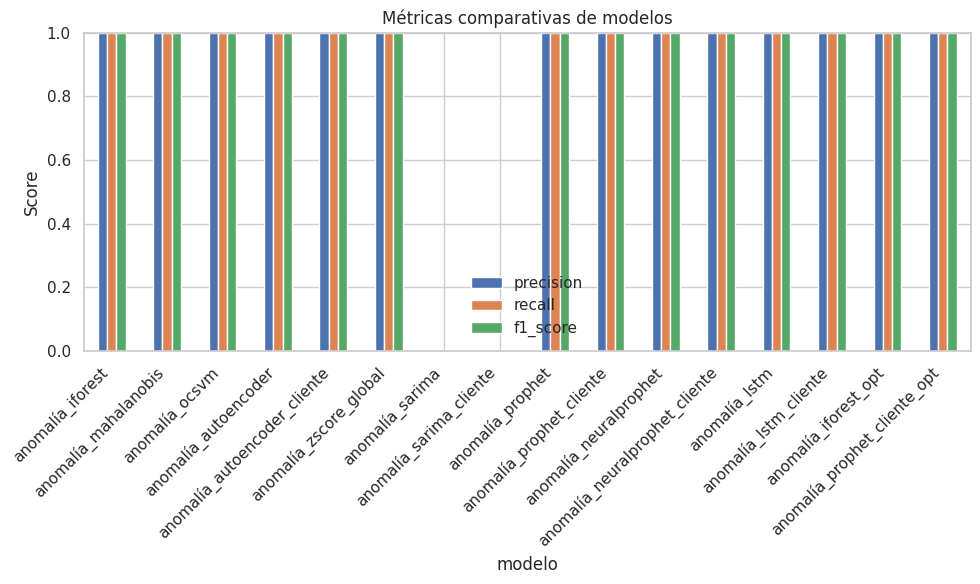

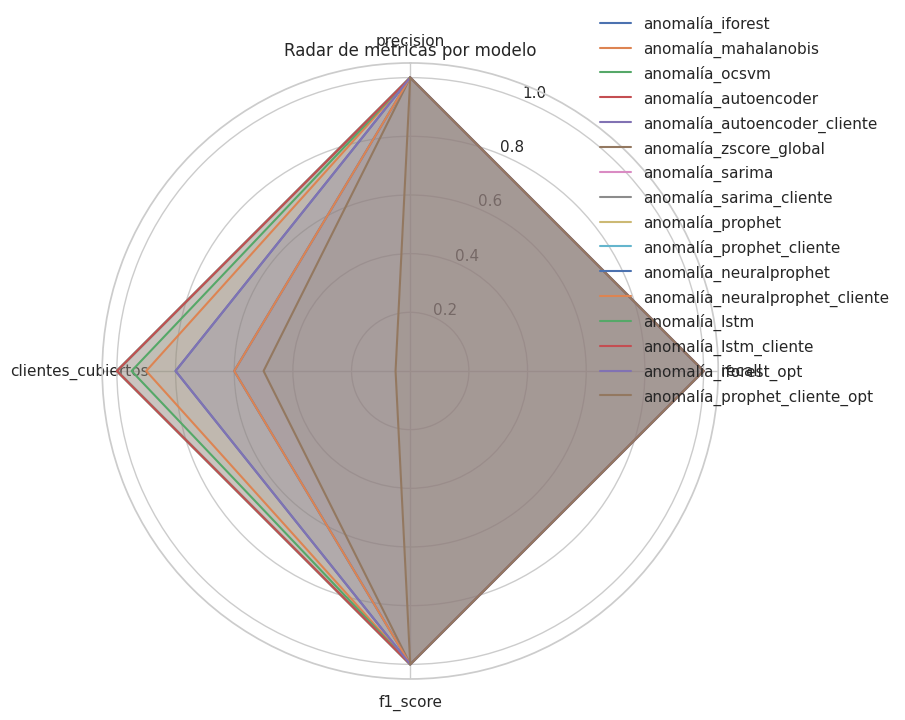

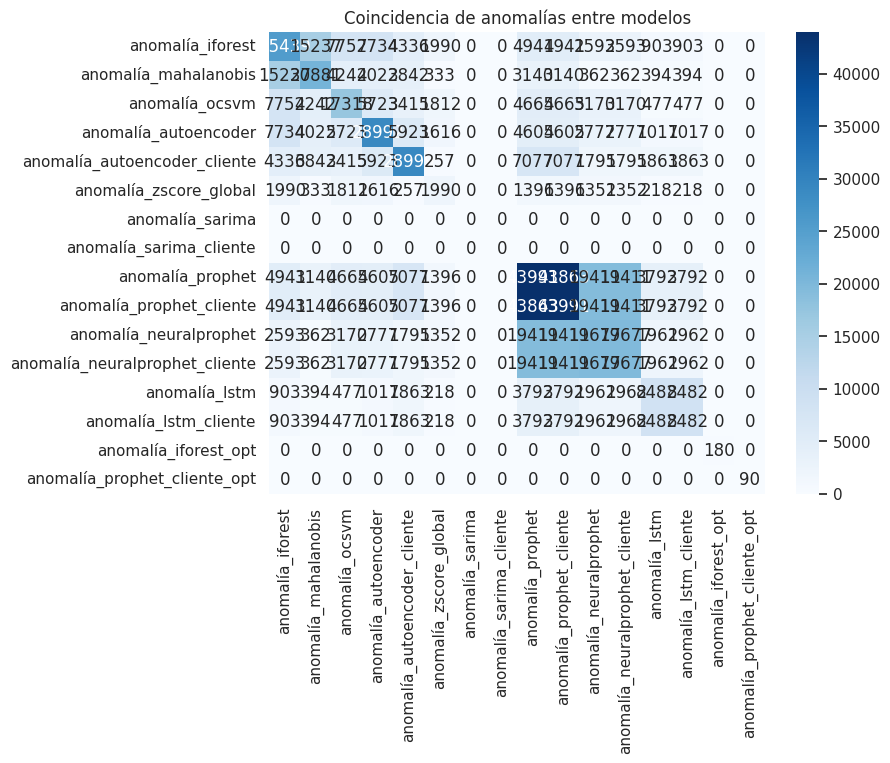

In [73]:
# Guardian de Fraudes – Consolidación y Métricas Comparativas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score
from math import pi

# 1. Cargar el archivo consolidado
df = pd.read_csv("consolidado_modelos_actualizado.csv", low_memory=False)

# 2. Identificar columnas de anomalía (excepto 'sospechoso_binario')
mapa_binario = {'Normal': 0, 'Anómalo': 1}
columnas_anomalias = [col for col in df.columns if col.startswith("anomalía")]
columnas_evaluar = [col for col in columnas_anomalias if col != "anomalía_fisico"]

# 3. Convertir etiquetas a binario y llenar NaN como 0
df[columnas_anomalias] = df[columnas_anomalias].replace(mapa_binario).infer_objects(copy=False).fillna(0)

# 4. Verificar si se puede comparar contra un ground truth
usar_modelo_fisico = 'anomalía_fisico' in df.columns

# 5. Funciones para métricas
def calcular_metricas(y_true, y_pred):
    return {
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1_score": f1_score(y_true, y_pred, zero_division=0)
    }

def cobertura_clientes(df, col):
    return df.groupby("cliente")[col].sum().gt(0).mean()

# 6. Calcular métricas por modelo
metricas = {}
for col in columnas_evaluar:
    y_pred = df[col]
    y_true = df['anomalía_fisico'] if usar_modelo_fisico else y_pred  # autoconsistencia si no hay físico
    m = calcular_metricas(y_true, y_pred)
    m["clientes_cubiertos"] = cobertura_clientes(df, col)
    metricas[col] = m

df_metricas = pd.DataFrame(metricas).T.reset_index().rename(columns={"index": "modelo"})
df_metricas.to_csv("metricas_comparativas_modelos.csv", index=False)
print("✅ Métricas generadas y guardadas como metricas_comparativas_modelos.csv")
display(df_metricas)

# 7. Gráfico de barras
df_metricas.set_index("modelo")[["precision", "recall", "f1_score"]].plot(kind="bar", figsize=(10,6))
plt.title("Métricas comparativas de modelos")
plt.ylabel("Score")
plt.xticks(rotation=45, ha="right")
plt.ylim(0, 1)
plt.grid(True)
plt.tight_layout()
plt.show()

# 8. Radar chart
categories = ['precision', 'recall', 'f1_score', 'clientes_cubiertos']
angles = [n / float(len(categories)) * 2 * pi for n in range(len(categories))] + [0]

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
for i, row in df_metricas.iterrows():
    values = row[categories].tolist() + [row[categories[0]]]
    ax.plot(angles, values, label=row['modelo'])
    ax.fill(angles, values, alpha=0.1)
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
plt.xticks(angles[:-1], categories)
plt.title("Radar de métricas por modelo")
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.show()

# 9. Heatmap de coincidencias
coincidencias = df[columnas_evaluar].astype(int).T.dot(df[columnas_evaluar].astype(int))
plt.figure(figsize=(8, 6))
sns.heatmap(coincidencias, annot=True, fmt="d", cmap="Blues")
plt.title("Coincidencia de anomalías entre modelos")
plt.show()


WARNING - (py.warnings._showwarnmsg) - <ipython-input-74-0b5f9d69798c>:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col_anomalias] = df[col_anomalias].replace(mapa_binario).infer_objects(copy=False).fillna(0)

  df[col_anomalias] = df[col_anomalias].replace(mapa_binario).infer_objects(copy=False).fillna(0)



✅ Métricas guardadas como metricas_comparativas_modelos.csv


modelo  precision  recall  f1_score  \
0                 anomalía_iforest        1.0     1.0       1.0   
1             anomalía_mahalanobis        1.0     1.0       1.0   
2                   anomalía_ocsvm        1.0     1.0       1.0   
3             anomalía_autoencoder        1.0     1.0       1.0   
4     anomalía_autoencoder_cliente        1.0     1.0       1.0   
5           anomalía_zscore_global        1.0     1.0       1.0   
6                  anomalía_sarima        0.0     0.0       0.0   
7          anomalía_sarima_cliente        0.0     0.0       0.0   
8                 anomalía_prophet        1.0     1.0       1.0   
9         anomalía_prophet_cliente        1.0     1.0       1.0   
10          anomalía_neuralprophet        1.0     1.0       1.0   
11  anomalía_neuralprophet_cliente        1.0     1.0       1.0   
12                   anomalía_lstm        1.0     1.0       1.0   
13           anomalía_lstm_cliente        1.0     1.0       1.0   
14            anomalía_iforest_opt        1.0     1.0       1.0   
15    anomalía_prophet_cliente_opt        1.0     1.0       1.0   

    clientes_cubiertos  
0                 0.80  
1                 0.90  
2                 0.95  
3                 1.00  
4                 1.00  
5                 0.50  
6                 0.00  
7                 0.00  
8                 1.00  
9                 1.00  
10                0.60  
11                0.60  
12                1.00  
13                1.00  
14                0.80  
15                0.05

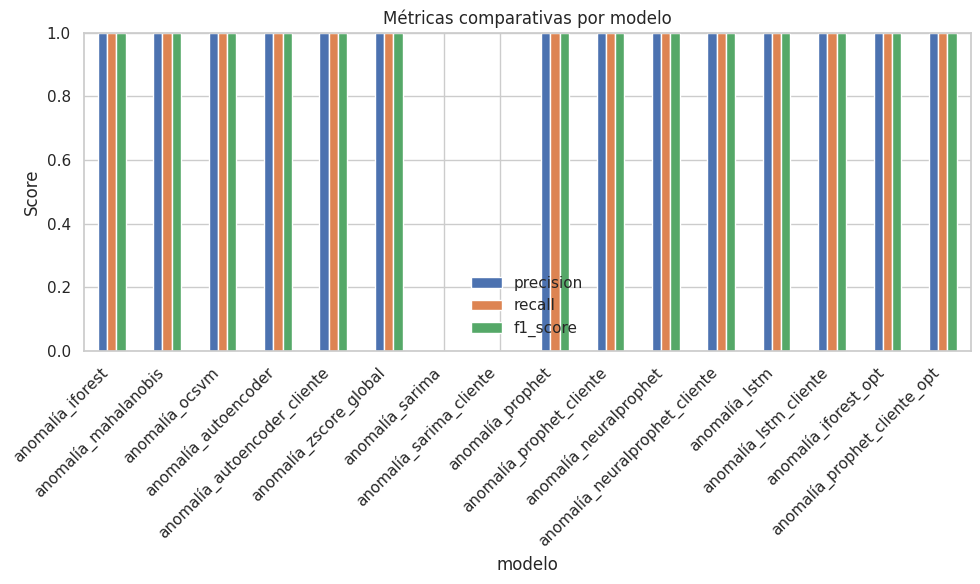

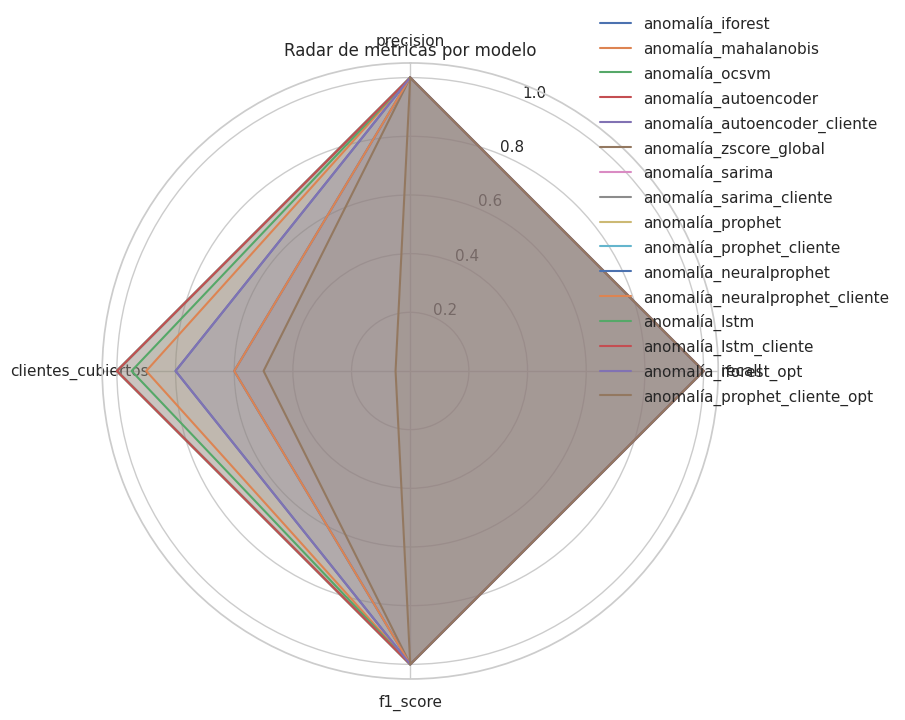

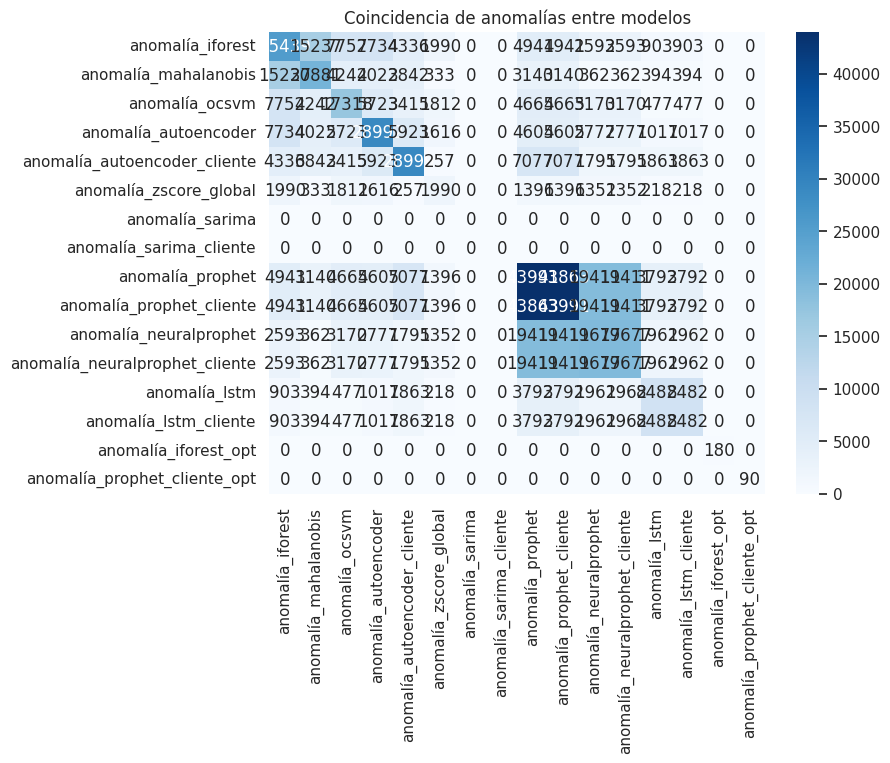

In [74]:
#Cargar consolidado
df = pd.read_csv("consolidado_modelos_actualizado.csv", low_memory=False)

# Detectar columnas de anomalías
mapa_binario = {'Normal': 0, 'Anómalo': 1}
col_anomalias = [col for col in df.columns if col.startswith("anomalía")]
col_evaluar = [col for col in col_anomalias if col != "anomalía_fisico"]

# Mapear valores binarios y reemplazar NaN por 0
df[col_anomalias] = df[col_anomalias].replace(mapa_binario).infer_objects(copy=False).fillna(0)
usar_fisico = 'anomalía_fisico' in df.columns

# Definir funciones
def calcular_metricas(y_true, y_pred):
    return {
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1_score": f1_score(y_true, y_pred, zero_division=0)
    }

def cobertura_clientes(df, col):
    return df.groupby("cliente")[col].sum().gt(0).mean()

# Calcular métricas por modelo
metricas = {}
for col in col_evaluar:
    y_pred = df[col]
    y_true = df["anomalía_fisico"] if usar_fisico else y_pred
    m = calcular_metricas(y_true, y_pred)
    m["clientes_cubiertos"] = cobertura_clientes(df, col)
    metricas[col] = m

# Crear y guardar DataFrame
df_metricas = pd.DataFrame(metricas).T.reset_index().rename(columns={"index": "modelo"})
df_metricas.to_csv("metricas_comparativas_modelos.csv", index=False)
print("✅ Métricas guardadas como metricas_comparativas_modelos.csv")
display(df_metricas)

# Barras de precisión, recall y F1
df_metricas.set_index("modelo")[["precision", "recall", "f1_score"]].plot(kind="bar", figsize=(10,6))
plt.title("Métricas comparativas por modelo")
plt.ylabel("Score")
plt.xticks(rotation=45, ha="right")
plt.ylim(0, 1)
plt.grid(True)
plt.tight_layout()
plt.show()

# Radar de métricas
categories = ['precision', 'recall', 'f1_score', 'clientes_cubiertos']
angles = [n / float(len(categories)) * 2 * pi for n in range(len(categories))] + [0]

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
for i, row in df_metricas.iterrows():
    values = row[categories].tolist() + [row[categories[0]]]
    ax.plot(angles, values, label=row['modelo'])
    ax.fill(angles, values, alpha=0.1)
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
plt.xticks(angles[:-1], categories)
plt.title("Radar de métricas por modelo")
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.show()

# Heatmap de coincidencia entre modelos
coincidencias = df[col_evaluar].astype(int).T.dot(df[col_evaluar].astype(int))
plt.figure(figsize=(8, 6))
sns.heatmap(coincidencias, annot=True, fmt="d", cmap="Blues")
plt.title("Coincidencia de anomalías entre modelos")
plt.show()


In [75]:

# Cargar las métricas generadas previamente
df_metricas = pd.read_csv("metricas_comparativas_modelos.csv")

# Definir modelos seleccionados
modelos_seleccionados = {
    "Eje 1 - Principal": "anomalía_iforest",
    "Eje 1 - Complementario": "anomalía_mahalanobis",
    "Eje 1 - Validación": "anomalía_autoencoder_cliente",
    "Eje 2 - Principal": "anomalía_prophet_cliente",
    "Eje 2 - Complementario": "anomalía_neuralprophet_cliente",
    "Eje 2 - Validación": "anomalía_lstm_cliente"
}

# Filtrar el DataFrame
df_seleccion = df_metricas[df_metricas["modelo"].isin(modelos_seleccionados.values())].copy()

# Agregar columna legible
df_seleccion["tipo_modelo"] = df_seleccion["modelo"].map({v: k for k, v in modelos_seleccionados.items()})

# Reorganizar columnas
df_seleccion = df_seleccion[
    ["tipo_modelo", "modelo", "precision", "recall", "f1_score", "clientes_cubiertos"]
]

# Ordenar por eje
orden_ejes = ["Eje 1 - Principal", "Eje 1 - Complementario", "Eje 1 - Validación",
              "Eje 2 - Principal", "Eje 2 - Complementario", "Eje 2 - Validación"]
df_seleccion["orden"] = df_seleccion["tipo_modelo"].apply(lambda x: orden_ejes.index(x))
df_seleccion = df_seleccion.sort_values("orden").drop(columns="orden").reset_index(drop=True)

# Mostrar
print("Tabla de modelos finales por eje:")
display(df_seleccion)

# (Opcional) Guardar CSV para el informe
df_seleccion.to_csv("metricas_modelos_seleccionados.csv", index=False)


✅ Tabla de modelos finales por eje:


tipo_modelo                          modelo  precision  recall  \
0       Eje 1 - Principal                anomalía_iforest        1.0     1.0   
1  Eje 1 - Complementario            anomalía_mahalanobis        1.0     1.0   
2      Eje 1 - Validación    anomalía_autoencoder_cliente        1.0     1.0   
3       Eje 2 - Principal        anomalía_prophet_cliente        1.0     1.0   
4  Eje 2 - Complementario  anomalía_neuralprophet_cliente        1.0     1.0   
5      Eje 2 - Validación           anomalía_lstm_cliente        1.0     1.0   

   f1_score  clientes_cubiertos  
0       1.0                 0.8  
1       1.0                 0.9  
2       1.0                 1.0  
3       1.0                 1.0  
4       1.0                 0.6  
5       1.0                 1.0